In [4]:
library(DBI)
library(dplyr)
##library(odbc)
##library(Hmisc)
library(devtools)
library(ggplot2)
##library(corrgram)
library(tidyverse)

ERROR: Error in library(DBI): there is no package called 'DBI'


### Mechkar code

In [5]:
############################################################################
#####   TABLE 1                                                         ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2016-03-09                                       ####
#####   Last Modified: 2018-12-19                                       ####
############################################################################

####################  FUNCTIONS  ###########################################
#### Usage:
####   x: character vector with the name of the variables
####   y: the name of the strata variable (optional)
####   rn: character vector with the text we want to replace the variable names
####   data: the dataset to be used
####   miss: include missing statistics: [0=none, 1=only for categorical variables, 2=for all variables]
####   excel: export the table to excel [0=no, 1=yes]
####   excel_file: the name of the excel file we want to save the table (optional)
####
###################

options(warn=-1)

Table1 <- function(x=NULL, y=NULL, rn=NULL, data=NULL, miss=3, catmiss=TRUE, formatted=TRUE, categorize=FALSE,
                    factorVars=NULL, maxcat=10, delzero=TRUE, decimals=1, messages=TRUE, excel=0, excel_file=NULL,
                    debug=FALSE) {
  ### define sub-functions
  Del <- NULL
  Pop <- NULL
  n <- NULL
  g1 <- function(var)c(Mean=mean(var,na.rm=TRUE), SD=stats::sd(var,na.rm=TRUE))
  g2 <- function(var)c(Median=stats::median(var,na.rm=TRUE), IQR=stats::quantile(var,c(0.25,0.75),na.rm=TRUE))
  msg <- NULL

  ### function for transforming variables to factors
  setFactors <- function(data=data, factorVars=factorVars, catmiss=catmiss, maxcat=maxcat) {
    if(is.null(factorVars)==TRUE) {
      aa <- sapply(sapply(data, unique), length)
      factorVars <- names(which(aa <= maxcat))
    }
    for (v in factorVars) {
      ct <- ifelse( ((is.null(factorVars)==FALSE & (v %in% factorVars)) | (is.null(factorVars)==TRUE & length(unique(data[[v]])) <= maxcat)),1,0)
      if (ct == 1) {
        data[[v]] <- factor(data[[v]])
        if(catmiss == TRUE & sum(is.na(data[[v]])==TRUE) > 0) {
          data[[v]] <- factor(data[[v]],levels=c(levels(data[[v]]),"Missing"))
          data[[v]][which(is.na(data[[v]])==TRUE)] <- "Missing"
        }
      }
    }
    return(data)
  }
  ### proceed to convert varibles to factors
  if (categorize == TRUE | is.null(factorVars)==FALSE ) {
    data <- setFactors(data, factorVars, catmiss, maxcat)
  }

  getSimpleTable  <- function(x=x, rn=rn, data=data, miss=miss, catmiss=catmiss,formatted=formatted,
                              categorize=categorize,maxcat=maxcat, delzero=delzero) {
    if (is.null(x)==TRUE) { x <- names(data)}
    if (is.null(rn)==TRUE) { rn <- x}
    ln <- length(x)
    pb <- utils::txtProgressBar(min=0,max=ln,style=3)
    msg <- NULL
    ### define the column names
    tableaaaa <- cbind(Del="Del",V1="Variables",V2="Categories",n="n","Population")
    tablebbbb <- cbind(Del="Del",V1="Variables",V2="Categories",n="n",val1="val1",val2="val2",val3="val3")
    tbl1 <- cbind(0,"Individuals","n",n=1, nrow(data))
    tbl2 <- cbind(0,"Individuals","n",n=1, nrow(data),NA,NA)
    tableaaaa <- rbind(tableaaaa,tbl1)
    tablebbbb <- rbind(tablebbbb,tbl2)
    q <- 1
    n <- 1
    ii <- 1
    for (v in x)
    {
      if (v %in% names(data)) {
        ### define if the actual variable has to be treated as numeric or factor
        ct <- ifelse(is.numeric(data[[v]])==TRUE & categorize==TRUE &
                       ((is.null(factorVars)==FALSE & (v %in% factorVars)) |
                          (is.null(factorVars)==TRUE & length(unique(data[[v]])) <= maxcat)),1,0)
        ### treat as numeric
        if (length(unique(data[v]))==0) {
          if (messages==TRUE) {
            msg <- c(msg, paste("The variable",v,"has no data... avoided"))
          }
        } else if (inherits(data[[v]], "Date")==TRUE) {
          if (messages==TRUE) {
            msg <- c(msg, paste("The variable",v,"is a date. Dates are not allowed in Table1... avoided"))
          }
        } else if (is.numeric(data[[v]])==TRUE & ct==0) {
          ## report mean and standard deviation
          t_n <- g1(data[[v]])
          tp <- paste(format(round(t_n[1],decimals),nsmall=1,big.mark=",")," (", format(round(t_n[2],decimals),nsmall=1,big.mark=","),")",sep="")
          tbl1 <- cbind(0,rn[q],"Mean (SD)",n=1, tp)
          tbl2 <- cbind(0,rn[q],"Mean (SD)",n=1,t_n[1],t_n[2],NA)
          tableaaaa <- rbind(tableaaaa,tbl1)
          tablebbbb <- rbind(tablebbbb,tbl2)
          ## report median and Interquartile ranges (25%,75%)
          t_n <- g2(data[[v]])
          tp <- paste(format(round(t_n[1],decimals),nsmall=1,big.mark=",")," (", format(round(t_n[2],decimals),nsmall=1,big.mark=","),"-", format(round(t_n[3],decimals),nsmall=1,big.mark=","), ")",sep="")
          tbl1 <- cbind(0,rn[q],"Median (IQR)",n=2, format(tp,big.mark=","))
          tbl2 <- cbind(0,rn[q],"Median (IQR)",n=2,t_n[1],t_n[2],t_n[3])
          tableaaaa <- rbind(tableaaaa,tbl1)
          tablebbbb <- rbind(tablebbbb,tbl2)
          ## report number and percent of missing
          if (miss >= 1) {
            #datams <- subset(data,is.na(data[[v]])==TRUE)
            datams <- data %>% filter(is.na(v)==TRUE)
            if (nrow(datams)>0) {
              data$cnt <- 1
              datams$cnt <- 1
              t_n <- table(data$cnt)
              t_m <- sum(datams$cnt)
              tp <- paste(format(t_m,big.mark=",")," (",format(round((t_m/t_n)*100,decimals),nsmall=1,big.mark=","),"%)",sep="")
              tbl1 <- cbind(0,rn[q],"Missing (%)",n=3, tp)
              tbl2 <- cbind(0,rn[q],"Missing (%)",n=3, t_m, (t_m/t_n)*100, NA)
            } else {
              tbl1 <- cbind(1,rn[q],"Missing (%)",n=3, " -- ")
              tbl2 <- cbind(1,rn[q],"Missing (%)",n=3, NA, NA, NA)
            }
            tableaaaa <- rbind(tableaaaa,tbl1)
            tablebbbb <- rbind(tablebbbb,tbl2)
          }
        } else {
          t_n <- table(data[[v]])
          ttotal <- sum(t_n)
          nm <- row.names(t_n)
          for (f in 1:length(nm)) {
            del1 <- ifelse(length(nm)==2 & (nm[f]=="No" | nm[f]=="no" | nm[f]==0 | nm[f]=="0" | nm[f]=="None" | nm[f]=="none"),1,0)
            tp <- t_n[f] / ttotal * 100
            pct <- paste(format(round(t_n[f],decimals),nsmall=0,big.mark=",")," (", format(round(tp,decimals),nsmall=1,big.mark=","), "%)",sep="")
            tbl1 <- cbind(del1,rn[q],nm[f],n=f, pct)             ########### delete rows 0/1 !!!!!!!!!
            tbl2 <- cbind(del1,rn[q],nm[f],n=f, t_n[f], tp, NA)  ########### delete rows 0/1 !!!!!!!!!
            tableaaaa <- rbind(tableaaaa,tbl1)
            tablebbbb <- rbind(tablebbbb,tbl2)
          }
          if (miss >= 2 & catmiss==FALSE ) {
            #datams <- subset(data,is.na(data[[v]])==TRUE)
            datams <- data %>% filter(is.na(v)==TRUE)
            if (nrow(datams)>0) {
              data$cnt <- 1
              datams$cnt <- 1
              t_n <- table(data$cnt)
              t_m <- sum(datams$cnt)
              tp <- paste(format(t_m,big.mark=",")," (",format(round((t_m/t_n)*100,decimals),nsmall=1,big.mark=","),"%)",sep="")
              tbl1 <- cbind(0,rn[q],"Missing (%)",n=f, tp)
              tbl2 <- cbind(0,rn[q],"Missing (%)",n=f, t_m, (t_m/t_n)*100, NA)
            } else {
              tbl1 <- cbind(1,rn[q],"Missing (%)",n=f, " -- ")
              tbl2 <- cbind(1,rn[q],"Missing (%)",n=f, NA, NA, NA)
            }
            tableaaaa <- rbind(tableaaaa,tbl1)
            tablebbbb <- rbind(tablebbbb,tbl2)
          }
        }
      } else {
        if (messages==TRUE) {
          msg <- c(msg, paste("The variable",v,"doesn't exists in the dataset... avoiding"))
        }
      }
      q <- q + 1
      if(debug==FALSE) {
        utils::setTxtProgressBar(pb,ii)
        ii <- ii + 1
      } else {
        message(v)
      }
    }
    if(formatted==TRUE) {
      return(tableaaaa)
    } else {
      return(tablebbbb)
    }
    close(pb)
  }

  pvals <- function(x=x,y=y,rn=rn,data=data,categorize=categorize,maxcat=maxcat) {
    ptab <- NULL
    if (is.null(y)==FALSE) {
      if (y %in% names(data)) {
        if (is.null(x)==TRUE) { x <- names(data)}
        if (is.null(rn)==TRUE | length(rn)<2) {rn <- x}
        q <- 1
        ptab <- cbind(V="Variables",pval="pval", n="n")

        ln <- length(x)
        ii <- 0
        pb <- utils::txtProgressBar(min=0,max=ln,style=3)

        for (v in x) {
          if (v %in% names(data)) {
            ct <- ifelse(is.numeric(data[[v]])==TRUE & categorize==TRUE & length(unique(data[[v]])) <= maxcat,1,0)
            if (is.numeric(data[[y]])==TRUE & categorize==TRUE & length(unique(data[[y]])) <= maxcat) {
              data[[y]] <- as.factor(data[[y]])
            } else if (is.numeric(data[[y]])==TRUE) {
              if (messages==TRUE) {
                msg <- c(msg, paste("The variable",y,"is not a factor. Please convert to factor or change the 'categorize' flag to TRUE."))
              }
              pval <- "Please rerun!!!"
            }
            if (is.numeric(data[[v]])==TRUE & length(unique(data[[v]])) > 1 & ct == 0) {
              ### first check for homoscedasticity
              tryCatch({
                if (stats::bartlett.test(data[[v]], data[[y]])[3] >= 0.05) {
                  pval <- suppressMessages(round(as.numeric(suppressMessages(car::Anova(stats::lm(data[[v]] ~ data[[y]])))[1, 4]), 3))
                } else {
                  pval <- suppressMessages(round(as.numeric(suppressMessages(car::Anova(stats::lm(data[[v]] ~ data[[y]]), white.adjust = TRUE))[1, 3]), 3))
                }
              }, warning = function(w) {
                suppressWarnings(w)
                #ww <- "suppress warnings..."
              }, error = function(e) {
                pval <- "---"
              })
            } else if (length(unique(data[[v]]))==1) {
              pval <- NA
            } else {
              if(length(unique(data[[v]])) < 15) {
                if (min(table(data[[v]],data[[y]])) > 5) {
                  pval <- round(as.numeric(stats::chisq.test(data[[v]],data[[y]])$p.val),3)
                } else {
                  if(min(table(data[[v]],data[[y]]))==0) {
                    #in cases where there are cells with zero, we use Fisher's exact test
                    tryCatch(
                      pval <- round(as.numeric(stats::fisher.test(data[[v]],data[[y]], workspace=1e9)$p.val),3),
                      error = function(e) {msg <- c(msg,paste0("Unable to calcualte the Fisher test for variables ",v," and ",y))})
                  } else {
                    pval <- round(as.numeric(stats::kruskal.test(data[[v]],data[[y]], workspace=1e9)$p.val),3)
                  }
                }
              } else {
                pval <- NA
              }
            }
            ptab <- rbind(ptab,cbind(V=rn[q],pval=pval,n=2))
          }
          if(debug==FALSE) {
            utils::setTxtProgressBar(pb,ii)
            ii <- ii + 1
          }
          q <- q + 1
        }
      }
    }
    return(ptab)
  }
  ####################### Begin analysis
  ##### check for x's witch have one unique values...get them out...
  vv <- NULL
  j <- 0
  jj <- NULL
  for(v in x) {
    if(length(unique(data[[v]])) < 2) {
      vv <- c(vv,v)
      j <- j + 1
      jj <- c(jj,j)
    }
  }
  warning(paste("The following variables have unique values and will not be included in the analysis:",vv))
  x <- setdiff(x, vv)
  if(is.null(rn)==FALSE & length(jj)>0) {
    rn <- rn[-jj]
  }

  ##### if y is null then make a simple table
  tabaaa1 <- getSimpleTable(x=x, rn=rn, data=data, miss=miss, catmiss=catmiss,formatted=formatted,categorize=categorize,maxcat=maxcat, delzero=delzero)
  tabaaa1 <- tibble::as_tibble(tabaaa1)
  ############################  CHANGE TO 5 !!!!!!!!!!!!!!
  if(length(tabaaa1) > 5) {
    names(tabaaa1) <- c("Del","V1","V2","n","Pop","pop2","pop3")
  } else {
    names(tabaaa1) <- c("Del","V1","V2","n","Pop")
  }
  ##### if y has two levels, then make a compound comparison
  if (is.null(y)==FALSE){
    if (y %in% names(data)) {
      if (is.factor(data[[y]])==FALSE) {
        if (length(levels(factor(data[[y]]))) > 8) {
          if (messages==TRUE) {
            message("The dependent variable has more than 8 levels, table too large!")
          }
        } else if(min(table(data[[y]]))==0) {
          message("The dependent variable has one or more levels with no individuals assigned!")
        } else {
          data[[y]] <- factor(data[[y]])
        }
      }
      if (length(levels(data[[y]])) >= 2) {
        for (lv in levels(data[[y]])) {
          #dtsub <- subset(data, data[[y]]==lv)
          dtsub <- data %>% filter(y==lv)
          tab <- getSimpleTable(x=x, rn=rn, data=dtsub, miss=miss, catmiss=catmiss, formatted=formatted,categorize=categorize,maxcat=maxcat, delzero=delzero)
          tab <- data.frame(tab)
          ############################  CHANGE TO 5 !!!!!!!!!!!!!!
          if(length(tab) > 5) {
            names(tab) <- c("Del","V1","V2","n",paste0(lv,"_1"),paste0(lv,"_2"),paste0(lv,"_3"))
          } else {
            names(tab) <- c("Del","V1","V2","n",lv)
          }
          ############################  CHANGE TO 5 !!!!!!!!!!!!!!
          tab[1,5] <- lv
          tabaaa1 <- suppressMessages(dplyr::left_join(tabaaa1, tab))
        }
        # what to do with dichotomous variables? We remove the "Zero" label...
        # clean unnecesary rows
        if (delzero == TRUE) {
          tabaaa1 <- dplyr::filter(tabaaa1,Del==0)
        }
        ### calculate the p-value
        ptab <- data.frame(pvals(x=x,y=y,rn=rn,data=data,categorize=categorize,maxcat=maxcat))
        names(ptab) <- c("V1","pval","n")
        tabaaa1 <- suppressMessages(dplyr::left_join(tabaaa1, ptab))
        tabaaa1 <- dplyr::filter(tabaaa1,Pop != " -- ") #%>%
      }
    }
  }

  tabaaa1 <- dplyr::select(tabaaa1,-n)
  tabaaa1 <- dplyr::select(tabaaa1,-Del)

  ##### Join the tables...
  #Sys.setenv(JAVA_HOME="")
  if (excel==1) {
    #wb <- xlsx::createWorkbook()
    #sheet1 <- xlsx::createSheet(wb, sheetName="Table 1")
    #xlsx::addDataFrame(tabaaa1,sheet1)
    #### save and close the workbook
    #xlsx::saveWorkbook(wb, excel_file)
    writexl::write_xlsx(tabaaa1,excel_file)
    return(tabaaa1)
  } else {
    return(tabaaa1)
  }
}

########################## END Table1 ###############

###################################################
####   Explore Data 
###################################################

exploreData <- function(data=data, y=NULL, rn=NULL, factorSize=10, dir=tempdir(), debug=FALSE, ...) {

  whatVarType <- function(var) {
    suppressWarnings(if (var=="integer" | var=="numeric") {
      return(1)
    } else if (var=="factor" | var=="character") {
      return(2)
    } else if (var=="Date" | "POSIXct" %in% var[[1]]) {
      return(3)
    } else {
      return(0)
    })
  }

  drawHistogram <- function(imgname=imgname, x=x) {
    d=stats::density(x, kernel = "gaussian",na.rm=TRUE)
    breakstar=(max(x,na.rm=TRUE) -min(x,na.rm=TRUE))/d$bw
    h=graphics::hist(x, breaks=breakstar)
    graphics::plot(h,main="",xlab=imgname)
    yfit<-seq(min(x,na.rm=TRUE),max(x,na.rm=TRUE),length=40)
    ffit<-stats::dnorm(yfit,mean=mean(x,na.rm=TRUE),sd=stats::sd(x,na.rm=TRUE))
    ffit <- ffit*diff(h$mids[1:2])*length(x)
    lines(yfit, ffit, col="blue", lwd=2)
  }

  drawFakeGraph <- function(imgname=imgname) {
    graphics::plot.window(xlim = c(0,0),ylim = c(0,0))
  }

  drawBars <- function(imgname=imgname, x=x) {
    graphics::plot(x)
  }

  drawGraphOne <- function(imgname=imgname, numVar=x, vartype=1) {
    if(vartype==1) {
      drawHistogram(imgname,numVar)
    } else if(vartype==2) {
      drawBars(imgname,numVar)
    } else {
      drawFakeGraph(imgname)
    }
  }

  getContinuousStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    ma <- mean(x, na.rm=TRUE)
    s <- stats::sd(x, na.rm=TRUE)
    me <- formatC(stats::median(x, na.rm=TRUE))
    q1 <- formatC(stats::quantile(x,1/4, na.rm=TRUE))
    q3 <- formatC(stats::quantile(x,3/4, na.rm=TRUE))
    mn <- formatC(min(x, na.rm=TRUE))
    mx <- formatC(max(x, na.rm=TRUE))
    html <- paste("<div class='Cell' style='align: top;'> <u>Data type</u>: Continuous <p> <u>Data length</u>: ",n ,"/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%)<p> <u>Mean</u>: ", formatC(ma), "\t <u>StdDev</u>: ", formatC(s), "<br><u>Median</u>: ",me,
                  "\t <u>IQR</u>: ", q1, "-", q3, "<br><u>Min</u>: ", mn, "\t <u>Max</u>: ", mx, "</div>")
    return(html)
  }

  getCategortyStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    l <- levels(x)
    s <- summary(x)
    htm <- "<ul>"
    if (length(l) < 5) {
      for (lv in l) {
        htm <- paste(htm, "<li><u>", lv, "</u>: ", s[[lv]], "</li>")
      }
      htm <- paste(htm,"</ul>")
    }
    html <- paste("<div class='Cell'> <u>Data type</u>: Categorical Data <p> <u>Data length</u>: ",n, "/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%) <p> <u>Number of levels</u>: ", length(l), "<br>", htm, "</div>")
    return(html)
  }

  getDatesStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    s <- summary(x)
    html <- paste("<div class='Cell'> <u>Data type</u>: Date <p> <u>Data length</u>: ",n, "/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%) <p> <u>Min date</u>: ", min(x, na.rm=TRUE), "<br><u>Max date</u>:",max(x, na.rm=TRUE) , "</div>")
    return(html)
  }

  getStats <- function(numVar=x, vartype=1) {
    if(vartype==1) {
      html <- getContinuousStats(numVar)
    } else if(vartype==2) {
      html <- getCategortyStats(numVar)
    } else if (vartype==3) {
      html <- getDatesStats(numVar)
    } else {
      html <- "<div class='Cell'></div>"
    }
    return(html)
  }

  getOutliers <- function(x) {
    bp <- graphics::boxplot(x,plot=FALSE)
    return(bp$out)
  }

  getOutlierGraph <- function(x) {
    #  mod <- tryCatch({
    outl <- getOutliers(x)
    df <- data.frame(x=x, cl=1)
    if(length(outl)>0) {
      df$cl[which(df$x %in% outl)] <- 2
    }
    #pl <- stats::scatter.smooth(df$x,col=df$cl)
    pl <- tryCatch({
      stats::scatter.smooth(df$x,col=df$cl,xlab="index")
    }, warning = function(w) {
      suppressWarnings(w)
      #n <- "warning!"
    }, error = function(e) {
      n <- "error!"
    }, finally = {
      graphics::plot(df$x ~ row.names(df),col=df$cl,xlab="index")
    })
    ma <- mean(x, na.rm=TRUE)
    s <- stats::sd(x, na.rm=TRUE)
    graphics::abline(h=ma-(2*s), col="red", lty=2)
    graphics::abline(h=ma+(2*s), col="red", lty=2)
    #  }, error = function(e) {
    #    pl <- drawFakeGraph("none")
    #  })
    return(pl)
  }

  getScatterGraph <- function(df=data,x,y,dtype=1) {
    #  mod <- tryCatch({
    if(dtype==1) {
      pl <- ggplot2::ggplot(df) + ggplot2::geom_smooth(ggplot2::aes(x=data[[x]], y=data[[y]]), method="loess") + ggplot2::xlab(x) + ggplot2::ylab(y)
    } else {
      pl <- ggplot2::ggplot(df) + ggplot2::geom_boxplot(ggplot2::aes(y=data[[x]], color=data[[y]])) + ggplot2::xlab(x) + ggplot2::ylab(y) + ggplot2::labs(color=y)
    }
    return(pl)
  }

  getOutliersHtml <- function(imgname=imgname, x=x, srcdir=srcdir) {
    bp <- getOutliers(x)
    if (length(unique(bp)) > 10) {
      xtrm <- paste("There are ", length(unique(bp)), " outlier values")
    } else if (length(unique(bp)) == 0) {
      xtrm <- "No outlier values found"
    } else {
      xtrm <- paste(formatC(unique(bp)), collapse=', ' )
    }
    #imgsrc = paste(paste0(srcdir,"/fig/"),imgname, "_2.png",sep="")
    imgsrc = paste(paste0("fig/"),imgname, "_2.png",sep="")
    html <- paste0("<div class='Cell'><img class='origimg' src='",imgsrc,"' height='150' width='250'><br> <u>Outlier values</u>: <br> ", xtrm, "</div>")
    return(html)
  }
  ################## Prepare for the report ###################
  #report <- paste(mydir,"/report",sep="")

  ################## Check for values for rn ##################
  if(!is.null(rn)) {
    if(length(rn)!=ncol(data)) {
      message("the value of the 'rn' argument was avoided because it does not have the same number of columns of the dataframe")
      rn <- NULL
    }
    xname <- rn
    names(xname) <- names(data)
  } else {
    xname <- NULL
  }

  report <- dir
  if (!file.exists(report)) {
    dir.create(report)
  }
  fig <- paste(report,"/fig",sep="")
  if (!file.exists(fig)) {
    dir.create(fig)
  }
  srcdir <- report

  # determine which columns are integer
  int_col <- which(sapply(data, is.integer))
  int_col <- c(int_col,(which(sapply(data, is.numeric))))
  mi <- vector()
  # find only those integers with less than 10 unique values and convert to factor
  for (li in int_col) {
    if (length(unique(data[,li])) < factorSize) {
      mi <- c(mi,li)
      if (is.factor(data[,li]) == FALSE) {
        data[,li] <- factor(data[,li])
      }
    }
  }

  str_col <- which(sapply(data, is.character))
  mi <- vector()
  # find only those integers with less than 10 unique values and convert to factor
  for (li in str_col) {
    mi <- c(mi,li)
    data[,li] <- factor(data[,li])
  }

  # create the html report page
  myhtml <- paste(report,"/report.html",sep="")
  cat("<!DOCTYPE html>
      <html>
      <head>
      <title>Data Visualization</title>
      <meta http-equiv='Content-Type' content='text/html; charset=UTF-8' />
      <link rel='stylesheet' href='http://code.jquery.com/mobile/1.4.5/jquery.mobile-1.4.5.min.css'>

      <script src='http://code.jquery.com/jquery-1.10.2.js'></script>
      <script>
      $(document).ready(function(){
      $('.onetoone').hide();
      });

      $(function() {
      $('.origimg').click(function(e) {
      $('#popup_img').attr('src',$(this).attr('src'));
      $('#myContainer').hide();
      var pos = $(document).scrollTop();
      $('#myContainer').css({'top':pos+20,'left':250, 'position':'absolute', 'border':'1px solid black', 'padding':'0px'});
      $('#myContainer').show();
      });
      $('#myContainer').click(function(e) {
      $('#myContainer').hide();
      });

      $('#myform2').submit(function(e) {
      e.preventDefault();
      });

      $('#onetoone').on('click',function() {
      console.log('onetone button - 1');
      $('#onetoone').hide();
      $('#aslist').show();
      // To show only individual rows:
      $('.Row').hide();
      $('.onetoone').show();
      // then we iterate
      var i = $('.Row').length;
      // Then we iterate
      var nxt = $('#idx').val();
      if (nxt < i & nxt >0) {
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(1)
      }
      console.log('onetone button - 2');
      });

      $('#aslist').on('click',function() {
      console.log('aslist button - 1');
      $('#onetoone').show();
      $('#aslist').hide();
      $('.onetoone').hide();
      $('.Row').show();
      console.log('aslist button - 2');
      });

      $('#less').on('click',function(){
      console.log('less button - 1');
      var i = $('.Row').length;
      var nxt = parseInt($('#idx').val(),10) - 1;
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(1)
      }
      console.log('less button - 2');
      });

      $('#more').on('click',function(){
      console.log('more button - 1');
      var i = $('.Row').length;
      var nxt = parseInt($('#idx').val(),10) + 1;
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(i)
      }
      console.log('more button - 2');
      });

      $('#idx').on('change', function(){
      console.log('idx changed - 1');
      var i = $('.Row').length;
      var nxt = $('#idx').val();
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(i)
      }
      console.log('idx changed - 2');
      });
      });

      </script>

      <style type='text/css'>
      .Table
      {
      display: table;
      }
      .Title
      {
      display: table-caption;
      text-align: center;
      font-weight: bold;
      font-size: larger;
      background-color:#4C6F50;
      color: #fff;
      }
      .Row
      {
      display: table-row;
      }
      .Row:nth-child(even) {
        background-color: #56882433;
      }
      .Cell
      {
      display: table-cell;
      border: solid;
      border-width: thin;
      padding-left: 5px;
      padding-right: 5px;
      vertical-align: top;
      font-family: Arial, Helvetica, sans-serif;
      font-size: 14px;
      }
      </style>

      </head>

      <body>
      <div id='pageone' data-role='main' class='ui-content'>
      ", file = myhtml, sep='\n',append=FALSE)

  html <- paste("<p><p><h1> Data Visualization & Exploration </h1>
                <form>
                <input type='button' id='onetoone' value='Show as Cards'>
                <input type='button' id='aslist' class='onetoone' value='Show as List'>
                </form>
                <p>
                ")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  # begin table
  alt1 <- ifelse(is.null(y)== TRUE, "", "<div class='Cell Title'> Dependent <br> Variable <br> Distribution </div>")
  html <- paste("<p><p>
                <div class='Table'>
                <div class='Row'>
                <div class='Cell Title'> Variable </div>
                <div class='Cell Title'> Distribution </div>
                <div class='Cell Title'> Descriptive <br> Statistics</div>
                <div class='Cell Title'> Outliers </div>"
                , alt1,
                "</div>")
  cat(html, file = myhtml, sep='\n', append=TRUE)

  #### determinate the type of each variable...
  data_types <- sapply(sapply(data, class), whatVarType)
  ln <- length(data)
  ii <- 0
  pb <- utils::txtProgressBar(min=0,max=ln,style=3)
  for(x in names(data)) {

    ## check if the value has at least more than one unique value...
    if(length(unique(data[[x]])) < 2) {
      message(paste("The variable",x,"has less than two unique values, so will not be included"))
    } else {

      if(debug==TRUE) {
        message(x)
      } else {
        pb <- utils::txtProgressBar(min=0,max=ln,style=3)
      }

      html <- paste("<div class='Row'><div class='Cell'><b>",x,"</b><p>",xname[x],"</p></div>")

      cat(html, file = myhtml, sep='\n', append=TRUE)
      #### initialize the first graph
      imgname = paste(fig,"/",x, "_1.png",sep="")
      #imgsrc = paste(paste0(srcdir,"/fig/"),x, "_1.png",sep="")
      imgsrc = paste("fig/",x, "_1.png",sep="")
      ### send the data with the type to generate the correct graph..
      grDevices::png(imgname)
      drawGraphOne(x, data[[x]], data_types[x])
      grDevices::dev.off()
      html <- paste0("<div class='Cell'><img class='origimg'  src='",imgsrc,"' height='150' width='150'><br></div>")
      cat(html, file = myhtml, sep='\n', append=TRUE)

      # second, show the statistics
      html <- getStats(data[[x]],data_types[x])
      cat(html, file = myhtml, sep='\n', append=TRUE)

      # third, determine the outliers
      imgname = paste(fig,"/",x, "_2.png",sep="")
      if(data_types[x]==1) {
        grDevices::png(imgname)
        getOutlierGraph(data[[x]])
        grDevices::dev.off()
        html <- getOutliersHtml(x,data[[x]],srcdir)
      } else {
        html <- "<div class='Cell'></div>"
      }
      cat(html, file = myhtml, sep='\n', append=TRUE)

      # fourth, if y is assigned, make a corresponding plot
      if(is.null(y)==FALSE) {
        imgname = paste(fig,"/",x, "_3.png",sep="")
        #imgsrc = paste(paste0(srcdir,"/fig/"),x, "_3.png",sep="")
        imgsrc = paste("fig/",x, "_3.png",sep="")
        grDevices::png(imgname)
        ### scatter.smooth(data[[x]] ~ data[[y]])
        #suppressWarnings(getScatterGraph(data,x,y,data_types[y]))
        plot(getScatterGraph(data,x,y,data_types[y]))
        grDevices::dev.off()
        html <- paste0("<div class='Cell'><img class='origimg' src='",imgsrc,"' height='150' width='150'><br></div>")
        cat(html, file = myhtml, sep='\n', append=TRUE)
      }
      html <- paste("</div>")
      cat(html, file = myhtml, sep='\n', append=TRUE)

      if(debug==FALSE) {
        utils::setTxtProgressBar(pb,ii)
        ii <- ii + 1
      }
    }
  }
  html <- paste("</div>")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  # end table
  html <- paste("</div>
                <div data-role='popup' id='myContainer' style='display: none;'>
                <img id='popup_img' src='' />
                </div>
                </div>
                </div>
                </div>
                <p>
                <div class='onetoone'>
                <form id='myform2'>
                <span> <input type='button' id='less' value=' << '> </span>
                <span> <input id='idx' name='idx' value='1'></input></span>
                <span> <input type='button' id='more' value=' >> '> </span>
                </form>
                </div>
                <p>
                </body></html>
                ")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  ## call the default browser or the one which is open (if any)
  browseURL(myhtml)
}

###################### END exploreData ###############


############################################################################
#####   GET THE MISSINGNESS OF A DATASET                                ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2017-05-07                                       ####
############################################################################
### search for the number & % of missinf
### then count the number of rows with complete data
getMissingness <- function(data, getRows=FALSE) {
  #utils::globalVariables(c("desc","na_count","na_cnt","rn","pred","dc"))
  desc <- na_count <- na_cnt <- rn <- pred <- dc <- NULL
  l <- nrow(data)
  vn <- names(data)
  ### copy the dataset and replace the NAs by 1 else 0
  nadf <- data
  cnt <- NULL
  miss <- function(x) return(sum(is.na(x) ))
  for(n in vn) {
    nadf[[n]] <- ifelse(is.na(nadf[[n]])==TRUE,1,0)
    cnt <- rbind(cnt, data.frame(n,sum(nadf[[n]])))
  }
  names(cnt) <- c("var","na_count")
  cnt$rate <- round((cnt$na_count / nrow(nadf))*100,1)
  ### now sum by column
  nadf$na_cnt <- 0
  nadf$na_cnt <- rowSums(nadf)
  ### order descending the count of mossings and leave only those with missings
  cnt <- cnt %>%
    dplyr::arrange(desc(na_count)) %>%
    dplyr::filter(na_count>0)
  #totmiss <- nadf %>% dplyr::filter(na_cnt==0) %>% dplyr::tally()
  totmiss <- nadf %>% dplyr::filter(na_cnt==0) %>% dplyr::summarise(n=n())
  idx <- NULL
  msg <- (paste("This dataset has ", as.character(totmiss), " (",as.character(round(totmiss/nrow(data)*100,1)),"%)" ," complete rows. Original data has ",nrow(data)," rows.",sep=""))
  ### check id needs to return the row indexes
  if(getRows==TRUE & totmiss != 0) {
    nadf$rn <- seq_len(nrow(data))
    idx <- nadf %>% dplyr::filter(na_cnt==0) %>% dplyr::select(rn)
  }
  message(list(head(cnt,n=10), msg))
  return(list(missingness=cnt, message=msg, rows=idx$rn))
}



In [6]:
movie_ff <- read.csv("C:/Users/dalit/DataScience/project/BoxOffice/movie_ff.csv")
movie_ff

ן..movie_id,budget,original_language,popularity,release_date,runtime,runtime_cat,revenue,sw_lang_en,sw_web_presence,...,depart_Camera_female,depart_Crew_female,depart_Custom_Mkup_female,depart_Directing_female,depart_Editing_female,depart_Lighting_female,depart_Production_female,depart_Sound_female,depart_Visual_Effects_female,depart_Writing_female
1,14000000,en,6.575393,20/02/2015,93,Short,12314651,1,0,...,0,0,0,0,0,0,0,0,0,0
2,40000000,en,8.248895,06/08/2004,113,Medium,95149435,1,0,...,0,0,0,0,0,0,3,0,0,1
3,3300000,en,64.299990,10/10/2014,105,Medium,13092000,1,1,...,0,1,0,0,0,0,2,0,0,0
4,1200000,hi,3.174936,09/03/2012,122,Large,16000000,0,1,...,0,0,0,0,0,0,0,0,0,0
5,0,ko,1.148070,05/02/2009,118,Medium,3923970,0,0,...,0,0,0,0,0,0,0,0,0,0
6,8000000,en,0.743274,06/08/1987,83,Short,3261638,1,0,...,0,0,0,0,0,0,0,0,0,0
7,14000000,en,7.286477,30/08/2012,92,Short,85446075,1,1,...,0,0,1,1,0,0,3,0,0,0
8,0,en,1.949044,15/01/2004,84,Short,2586511,1,0,...,0,0,0,1,0,0,0,0,0,0
9,0,en,6.902423,16/02/1996,100,Medium,34327391,1,0,...,0,0,0,0,0,0,0,0,0,0
10,6000000,en,4.672036,16/04/2003,91,Short,18750246,1,0,...,1,0,1,0,0,0,1,0,0,0


In [7]:
movie_ff1 <- read.csv("C:/Users/dalit/DataScience/project/BoxOffice/num1.csv")
movie_ff1

X,budget,release_date,sw_lang_en,sw_tagline,release_month,seasonality,countries_cnt,lang_RU,actor0_movies_cnt,...,genre_mystery,genre_family,depart_Art,depart_Custom_Mkup,depart_Lighting,depart_Visual_Effects,depart_Camera_female,depart_Directing_female,depart_Production_female,depart_Writing_female
1,1.40e+07,20/02/2015,1,1,2,-15309317,1,0,18,...,0,0,12,13,4,4,0,0,0,0
2,4.00e+07,06/08/2004,1,1,8,-33273015,1,0,3,...,0,1,0,0,0,0,0,0,3,1
3,3.30e+06,10/10/2014,1,1,10,-28659422,1,0,7,...,0,0,5,5,1,3,0,0,2,0
4,1.20e+06,09/03/2012,0,0,3,-7149862,1,0,2,...,0,0,0,0,0,0,0,0,0,0
5,0.00e+00,05/02/2009,0,0,2,-15309317,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,8.00e+06,06/08/1987,1,0,8,-33273015,0,0,1,...,0,1,1,0,0,4,0,0,0,0
7,1.40e+07,30/08/2012,1,1,8,-33273015,2,0,8,...,0,0,4,12,4,2,0,1,3,0
8,0.00e+00,15/01/2004,1,1,1,-50746591,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,0.00e+00,16/02/1996,1,1,2,-15309317,1,0,12,...,0,1,0,0,0,0,0,0,0,0
10,6.00e+06,16/04/2003,1,1,4,-28405871,1,0,10,...,0,0,3,1,0,0,1,0,1,0


In [95]:
## Fixing the type of the columns:
movie_ff$runtime <- as.numeric(movie_ff$runtime)
movie_ff$revenue <- as.numeric(movie_ff$revenue)
movie_ff$release_year <- as.numeric(movie_ff$release_year)
movie_ff$release_month <- as.numeric(movie_ff$release_month)
movie_ff$release_day <- as.numeric(movie_ff$release_day)
movie_ff$producers_cnt <- as.numeric(movie_ff$producers_cnt)
movie_ff$sw_female_actor0 <- as.numeric(movie_ff$sw_female_actor0)
movie_ff$sw_female_actor1 <- as.numeric(movie_ff$sw_female_actor1)
movie_ff$sw_female_actor2 <- as.numeric(movie_ff$sw_female_actor2)
movie_ff$sw_male_actor0 <- as.numeric(movie_ff$sw_male_actor0)
movie_ff$sw_male_actor1 <- as.numeric(movie_ff$sw_male_actor1)
movie_ff$sw_male_actor2 <- as.numeric(movie_ff$sw_male_actor2)
movie_ff$actor0_prev_revenue <- as.numeric(movie_ff$actor0_prev_revenue)
movie_ff$actor1_prev_revenue <- as.numeric(movie_ff$actor1_prev_revenue)
movie_ff$actor2_prev_revenue <- as.numeric(movie_ff$actor2_prev_revenue)
movie_ff$original_language <- factor(movie_ff$original_language)
movie_ff$popularity_group <- factor(movie_ff$popularity_group)
movie_ff$runtime_cat <- factor(movie_ff$runtime_cat)
movie_ff$keyword_cnt <- factor(movie_ff$keyword_cnt)
movie_ff$release_year <- factor(movie_ff$release_year)
movie_ff$release_month <- factor(movie_ff$release_month)
movie_ff$release_day <- factor(movie_ff$release_day)
movie_ff$seasonality <- factor(movie_ff$seasonality)
movie_ff$producers_cnt <- factor(movie_ff$producers_cnt)
movie_ff$countries_cnt <- as.numeric(movie_ff$countries_cnt)

ERROR: Error in `$<-.data.frame`(`*tmp*`, popularity_group, value = structure(integer(0), .Label = character(0), class = "factor")): replacement has 0 rows, data has 7375


### EDA functions: ###

In [8]:
#Check type of file:
class(movie_ff1)

[1] "data.frame"

In [30]:
#Get general information about all colums in the df:
sum <- summary(movie_ff1)
sum

       X            budget           release_date    sw_lang_en    
 Min.   :   1   Min.   :        0   1499   :  10   Min.   :0.0000  
 1st Qu.:1844   1st Qu.:        0   1349   :   8   1st Qu.:1.0000  
 Median :3688   Median :  8000000   791    :   7   Median :1.0000  
 Mean   :3688   Mean   : 22666657   2406   :   7   Mean   :0.8591  
 3rd Qu.:5532   3rd Qu.: 29000000   2513   :   7   3rd Qu.:1.0000  
 Max.   :7375   Max.   :380000000   3977   :   7   Max.   :1.0000  
                                    (Other):7329                   
   sw_tagline     release_month     seasonality        countries_cnt   
 Min.   :0.0000   Min.   : 1.000   Min.   :-50746591   Min.   : 0.000  
 1st Qu.:1.0000   1st Qu.: 4.000   1st Qu.:-33273015   1st Qu.: 1.000  
 Median :1.0000   Median : 7.000   Median :-15309317   Median : 1.000  
 Mean   :0.8045   Mean   : 6.844   Mean   : -1337484   Mean   : 1.335  
 3rd Qu.:1.0000   3rd Qu.:10.000   3rd Qu.: 32322910   3rd Qu.: 1.000  
 Max.   :1.0000   Max.  

In [31]:
df_sum <- data.frame(sum)
df_sum

Var1,Var2,Freq
,X,Min. : 1
,X,1st Qu.:1844
,X,Median :3688
,X,Mean :3688
,X,3rd Qu.:5532
,X,Max. :7375
,X,NA
,budget,Min. : 0
,budget,1st Qu.: 0
,budget,Median : 8000000


In [101]:
##cor.test(movie_ff$budget, movie_ff$revenue, method = "spearman")

In [100]:
##rcorr(movie_ff$budget, movie_ff$revenue, method = "spearman")

## Graphs:

In [99]:
##boxplot((log(movie_ff$budget)+1))

In [98]:
##pie(table(movie_ff$runtime_cat))

In [97]:
### check if relevant:
##pairs(movie_ff[,16:17])

### CHECK FOR NORMAL DISTRIBUTION?

In [45]:
### Mechkar analysis:
exploreData(movie_ff)

  |===================================================================== |  99%

In [11]:
exploreData(movie_ff1)

  |====================================================================  |  97%

In [21]:
movie_ff1$release_date <- as.factor(movie_ff1$release_date)

In [102]:
library(ggplot2)
ggplot(data=movie_ff1$release_date)+
  geom_bar(aes(x=higrisk))


ERROR: Error: `data` must be a data frame, or other object coercible by `fortify()`, not a factor


In [22]:
hist(movie_ff1$release_date)


ERROR: Error in hist.default(movie_ff1$release_date): 'x' must be numeric


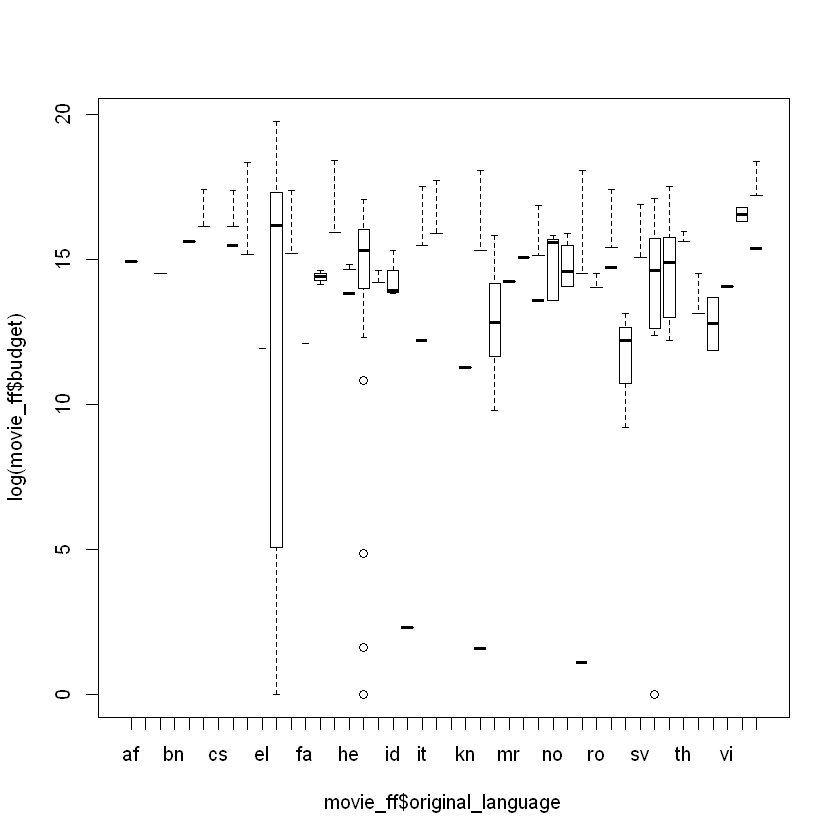

In [28]:
plot(log(movie_ff$budget) ~ movie_ff$original_language)


In [46]:
####################### Analyze budget:
summary(movie_ff$budget)
table(movie_ff$budget)
sum(is.na(movie_ff$budget))
sd(movie_ff$budget, na.rm = TRUE)
nrow(table(movie_ff$budget))
max(table(movie_ff$budget))
calculate_mode(movie_ff$budget)
hist(movie_ff$budget, breaks = 400, na.rm = TRUE)
boxplot(movie_ff$budget, na.rm = TRUE)

plot(movie_ff$budget ~ movie_ff$revenue)
mod1 <- lm(movie_ff$budget ~ movie_ff$revenue)
pred1<-predict(mod1)
abline(reg=mod1, col="red")
summary(mod1)
cor.test(movie_ff$budget,movie_ff$revenue,method="spearman")
##log transformation in order to see the lower values
hist(log(movie_ff$budget), breaks = 50, na.rm = TRUE)

##relationship between budget and original_language
plot(movie_ff$budget ~ movie_ff$original_language)
subset_zero <- subset(movie_ff, movie_ff$budget==0)

#### calculate the IQR and outliers:
Q <- quantile(movie_ff$budget, probs=c(.25, .75), na.rm = TRUE)
iqr<-IQR(movie_ff$budget, na.rm=TRUE)
lower<-Q[1]-1.5*iqr
higher<-Q[2]+1.5*iqr
outliers <- boxplot(movie_ff$budget, plot=FALSE)$out

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
        0         0   8000000  22666657  29000000 380000000 


        0         1         2         3         4         5         6         7 
     2012         9         1         4         2         3         2         2 
        8        10        11        12        15        20        25        28 
        3         2         1         1         1         1         1         1 
       30        50        75        93       113       118       130       218 
        2         1         1         1         1         1         1         1 
      250       280       337       344       450       500       592      2500 
        1         1         1         1         1         3         1         1 
     5000      6000      7000      7300      8000     10000     11178     11180 
        1         1         1         1         1         2         1         1 
    12000     15000     16000     17000     17311     18000     20000     22361 
        1         3         1         1         1         1         1         1 
    24500     24554     250

[1] 0

[1] 36987354

[1] 704

[1] 2012

ERROR: Error in calculate_mode(movie_ff$budget): could not find function "calculate_mode"


In [107]:
iqr<-IQR(movie_ff$budget, na.rm=TRUE)
iqr

[1] 2.9e+07

In [103]:
#### calculate the IQR and outliers:
Q <- quantile(movie_ff$budget, probs=c(.25, .75), na.rm = TRUE)
iqr<-IQR(movie_ff$budget, na.rm=TRUE)
lower<-Q[1]-1.5*iqr
lower
higher<-Q[2]+1.5*iqr
outliers <- boxplot(movie_ff$budget, plot=FALSE)$out
table(outliers)

25% 
-43500000

outliers
  7.3e+07   7.4e+07  74500000   7.5e+07   7.6e+07   7.8e+07  78146652   7.9e+07 
        4         2         1        52         4         4         1         4 
    8e+07  80341000   8.1e+07   8.2e+07  82500000   8.3e+07   8.4e+07   8.5e+07 
       65         1         1         4         1         1         2        32 
  8.6e+07   8.7e+07   8.8e+07     9e+07   9.2e+07  92620000   9.3e+07   9.4e+07 
        2         2         3        37         7         1         3         4 
  9.5e+07   9.7e+07  97250400   9.8e+07   9.9e+07     1e+08  1.02e+08  1.03e+08 
        8         2         1         2         1        47         3         3 
 1.05e+08  1.07e+08  1.08e+08   1.1e+08  1.12e+08  1.13e+08  1.15e+08  1.16e+08 
        9         1         2        24         1         1         7         2 
 1.17e+08   1.2e+08  1.23e+08  1.25e+08  1.26e+08  1.27e+08 127500000   1.3e+08 
        1        19         1        18         1         1         1        21 
 1.32e+08  1.33e+08

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
       0        0  5500000 13517000 20000000 72500000      624 

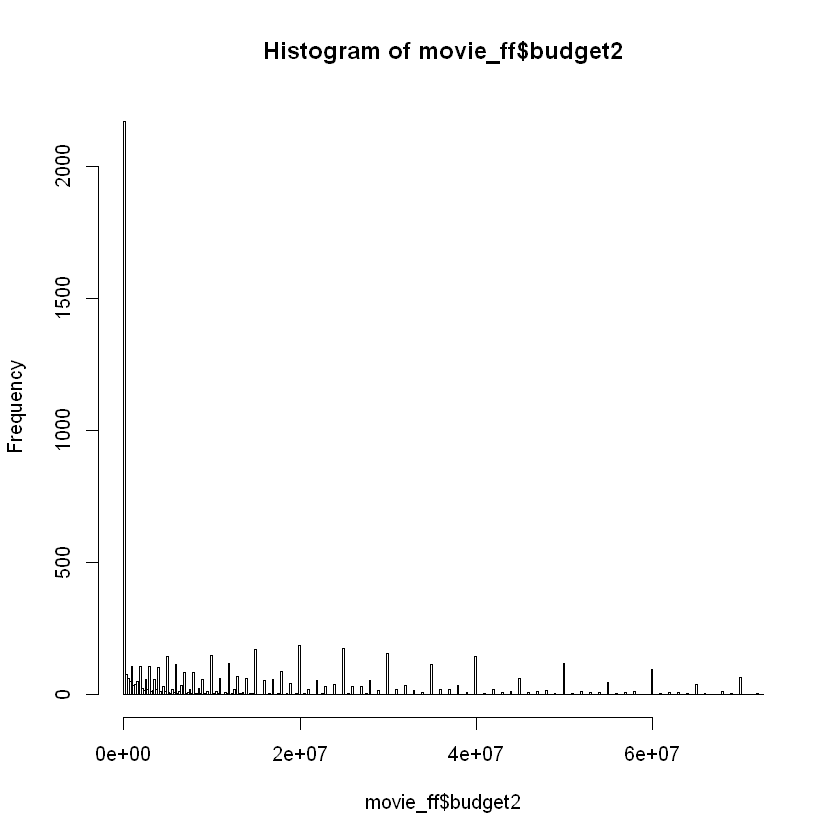

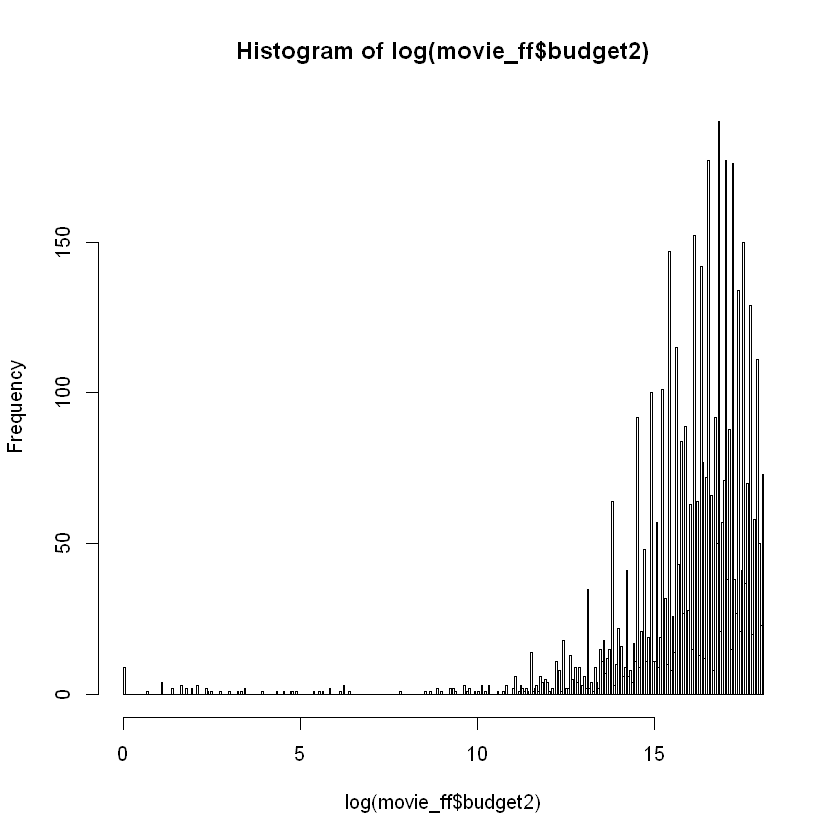

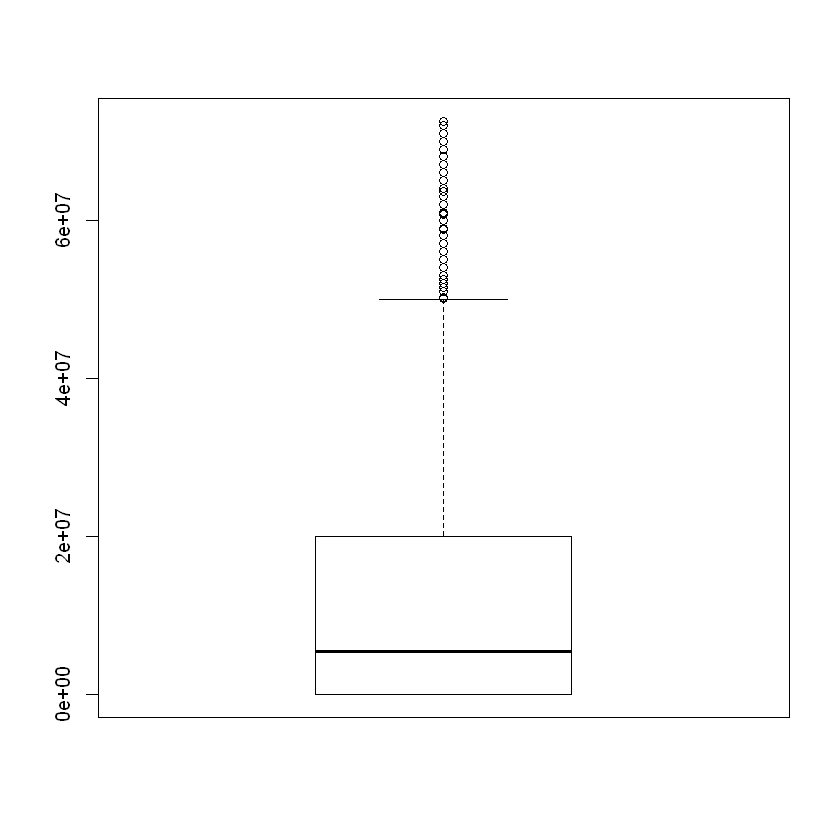


Call:
lm(formula = movie_ff$budget2 ~ movie_ff$revenue)

Residuals:
      Min        1Q    Median        3Q       Max 
-13944848 -13406613  -7906613   6593387  58676653 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      13945036.8   587472.2  23.737   <2e-16 ***
movie_ff$revenue     -189.3      242.0  -0.782    0.434    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 17510000 on 6749 degrees of freedom
  (624 observations deleted due to missingness)
Multiple R-squared:  9.058e-05,	Adjusted R-squared:  -5.758e-05 
F-statistic: 0.6113 on 1 and 6749 DF,  p-value: 0.4343



	Spearman's rank correlation rho

data:  movie_ff$budget2 and movie_ff$revenue
S = 5.1678e+10, p-value = 0.524
alternative hypothesis: true rho is not equal to 0
sample estimates:
         rho 
-0.007757205 


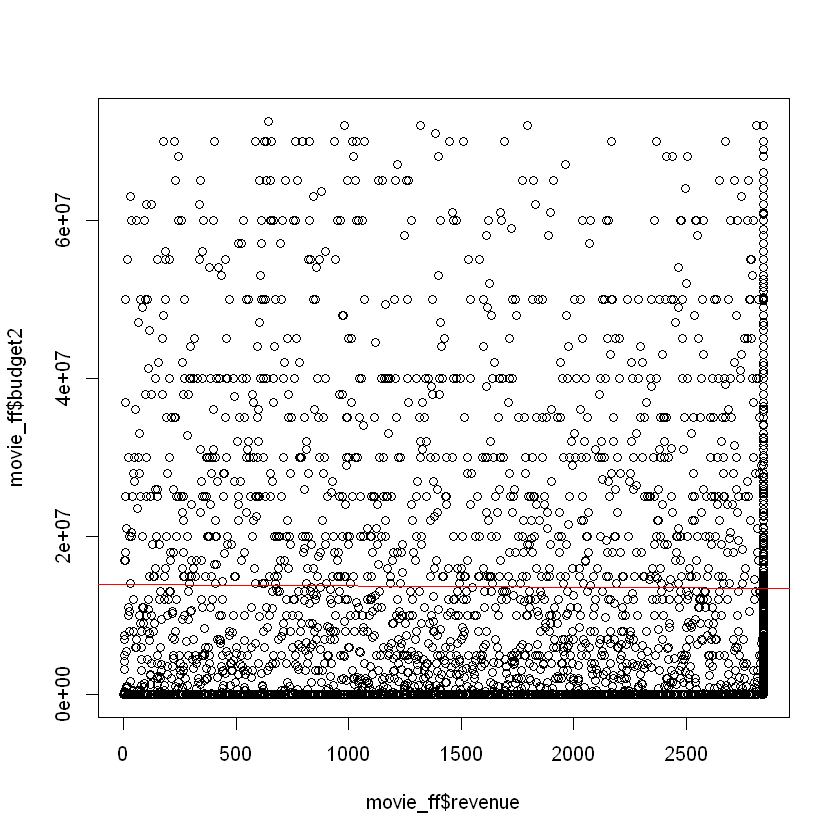

In [104]:
#### check distribution without outliers
movie_ff$budget2 <- movie_ff$budget
movie_ff$budget2[movie_ff$budget2 < lower | movie_ff$budget2 > higher] <- NA
summary(movie_ff$budget2)
hist(movie_ff$budget2, breaks = 400, na.rm = TRUE)
hist(log(movie_ff$budget2), breaks = 400, na.rm = TRUE)
boxplot(movie_ff$budget2, na.rm = TRUE)
plot(movie_ff$budget2 ~ movie_ff$revenue)
mod2 <- lm(movie_ff$budget2 ~ movie_ff$revenue)
pred1<-predict(mod2)
abline(reg=mod2, col="red")
summary(mod2)
cor.test(movie_ff$budget2,movie_ff$revenue,method="spearman")


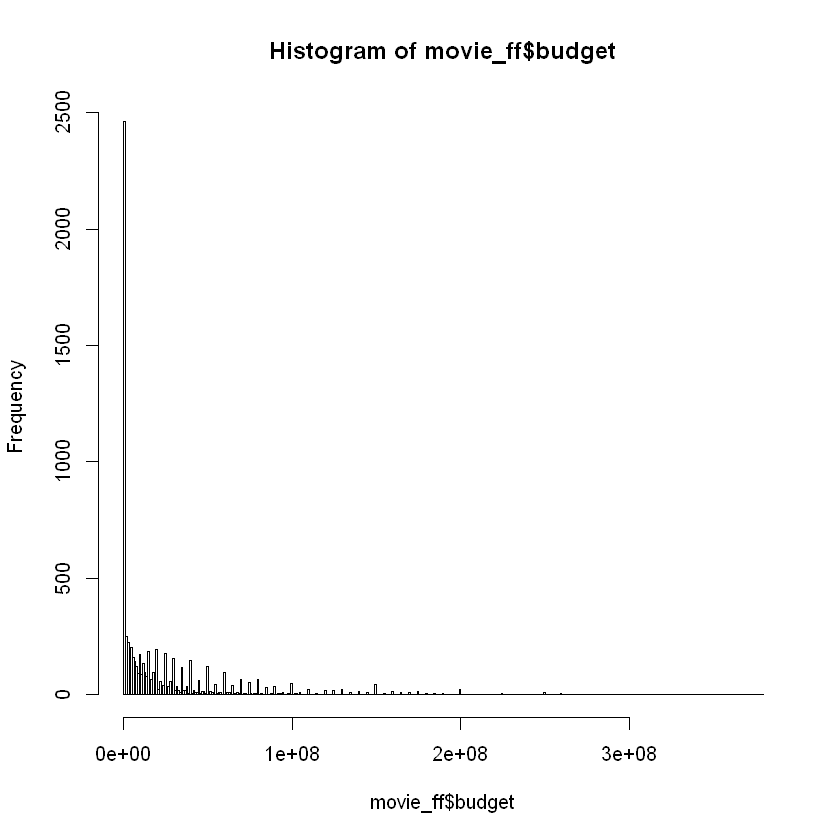

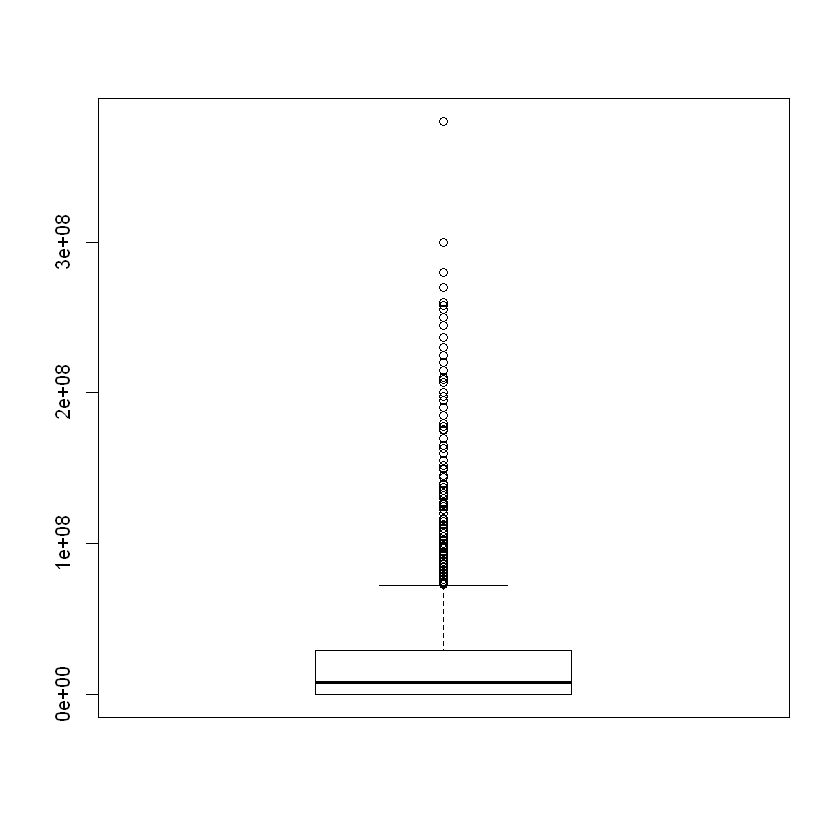


Call:
lm(formula = movie_ff$budget ~ movie_ff$revenue)

Residuals:
      Min        1Q    Median        3Q       Max 
-22786440 -22440447 -14786440   6213560 357781302 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      2.220e+07  1.188e+06   18.68   <2e-16 ***
movie_ff$revenue 2.057e+02  4.894e+02    0.42    0.674    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 36990000 on 7373 degrees of freedom
Multiple R-squared:  2.396e-05,	Adjusted R-squared:  -0.0001117 
F-statistic: 0.1767 on 1 and 7373 DF,  p-value: 0.6743


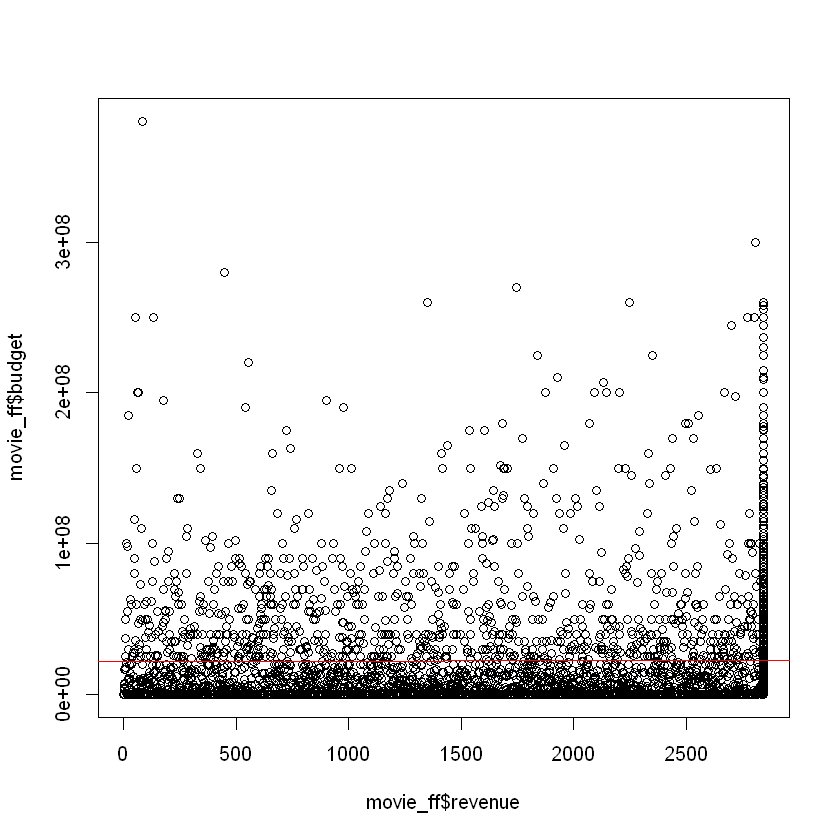

In [54]:
hist(movie_ff$budget, breaks = 400, na.rm = TRUE)
boxplot(movie_ff$budget, na.rm = TRUE)

plot(movie_ff$budget ~ movie_ff$revenue)
mod1 <- lm(movie_ff$budget ~ movie_ff$revenue)
pred1<-predict(mod1)
abline(reg=mod1, col="red")
summary(mod1)


Call:
lm(formula = movie_ff$budget ~ movie_ff$revenue)

Residuals:
      Min        1Q    Median        3Q       Max 
-22786440 -22440447 -14786440   6213560 357781302 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      2.220e+07  1.188e+06   18.68   <2e-16 ***
movie_ff$revenue 2.057e+02  4.894e+02    0.42    0.674    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 36990000 on 7373 degrees of freedom
Multiple R-squared:  2.396e-05,	Adjusted R-squared:  -0.0001117 
F-statistic: 0.1767 on 1 and 7373 DF,  p-value: 0.6743



	Spearman's rank correlation rho

data:  movie_ff$budget and movie_ff$revenue
S = 6.7125e+10, p-value = 0.7289
alternative hypothesis: true rho is not equal to 0
sample estimates:
         rho 
-0.004037137 


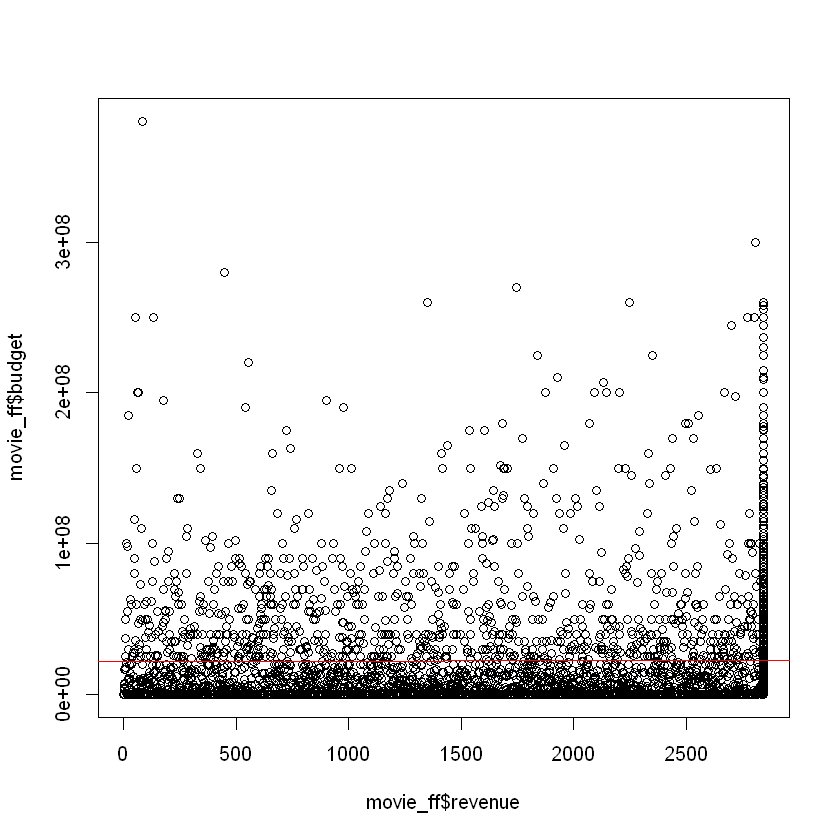

In [47]:
plot(movie_ff$budget ~ movie_ff$revenue)
mod1 <- lm(movie_ff$budget ~ movie_ff$revenue)
pred1<-predict(mod1)
abline(reg=mod1, col="red")
summary(mod1)
cor.test(movie_ff$budget,movie_ff$revenue,method="spearman")

[1]  14000000  40000000   3300000   1200000        NA   8000000  14000000
   [8]        NA        NA   6000000   1000000        NA  15000000  53000000
  [15] 102000000    500000  26000000        NA   8000000  32000000  80000000
  [22]   4000000        NA        NA        NA        NA  10000000  11000000
  [29]   6000000  45000000  13000000        NA  90000000        NA 140000000
  [36]  30000000        NA  50000000        NA   3800000        NA   3000000
  [43]  25000000   6000000  15000000   3906840  80000000  44000000        NA
  [50]  38000000    560000  12000000        NA        NA  20000000        NA
  [57]        NA 125000000        NA  14000000 150000000   4000000        NA
  [64]   5000000  12000000   1500000  12000000        NA   2000000  85000000
  [71]  29000000        NA  11000000        NA    445000  17000000    500000
  [78]   6000000        NA   1500000  15000000  10284523  43000000  28000000
  [85]   2000000  50000000   8000000   7500000  20000000        NA  30000000
  [92]        NA  35000000        NA  15000000        NA   2500000        NA
  [99]  10500000   6000000   7000000  60000000        NA        NA        NA
 [106]  10900000  31000000  72000000  14000000  15000000  75000000  35000000
 [113] 100000000  20000000  93000000  25000000        NA        NA        NA
 [120]  12716953  90000000 150000000   1500000  25000000   7500000  40000000
 [127]        NA  10000000  18000000   2400000   4000000   6000000        NA
 [134]  65000000  10000000   2000000        NA   9000000        NA 110000000
 [141]  14320000        NA   3500000  18000000   4000000        NA        NA
 [148]  39200000        NA  25000000        NA        NA        NA   4000000
 [155]        NA  20000000   3500000        NA  63600000  32000000   3500000
 [162]        NA    125000   9000000  40000000        NA        NA  19000000
 [169]   5000000   2000000        NA        NA   3500000  11000000  12468389
 [176]  38000000  90000000        NA  15000000  32000000  30000000        NA
 [183]        NA   6000000  82500000  14000000   5000000    259000 180000000
 [190]        NA   4000000  40000000        NA        NA   4500000        NA
 [197]   7000000  60000000  24000000  12600000  85000000  10000000  55000000
 [204]  75000000   3200000   2000000        NA  15000000        NA 100000000
 [211]  22000000   7000000        NA   6700000  20000000  35000000  35000000
 [218]  10000000        NA   2600000  12000000        NA   5000000  49000000
 [225]        NA        NA  50000000   7500000   6244087  14000000 110000000
 [232]    800000        NA        NA  30000000        NA  15000000        NA
 [239]  22000000  20000000        NA  70000000        NA        NA        NA
 [246]  19000000  23000000  18339750 102000000   7920000  12560000  98000000
 [253]   8500000        NA     11178   9500000  55000000   1000000        NA
 [260]     24554        NA  50000000        NA  10000000        NA  15000000
 [267]  15000000     27000  40000000        NA  21000000  72500000  12000000
 [274]  50000000  65000000        NA   2915739  70000000        NA  65000000
 [281]        NA  30000000  12000000  19000000   7000000  25000000   9000000
 [288]        NA  24000000  28000000   6000000  16000000  65000000        NA
 [295] 160000000        NA  60000000  25000000   3000000   9000000  11000000
 [302]    225000        NA        NA        NA 100000000 100000000 108000000
 [309]  30000000  26000000  15000000   9500000  16000000        NA 175000000
 [316]  55000000  60000000 115000000  20000000  12000000        NA  85000000
 [323] 135000000  90000000  12000000  71000000  26000000  40000000  15000000
 [330] 100000000        NA  23000000   5000000        NA         1  25000000
 [337]  75000000        NA  30000000  11000000        NA  27000000        NA
 [344]        NA  60000000        NA  36000000        12   1000000    350000
 [351] 110000000   7200000        NA   7000000  20500000        NA 130000000
 [358]  45000000  75000000  65000000        NA   2200000   3300000  15400000

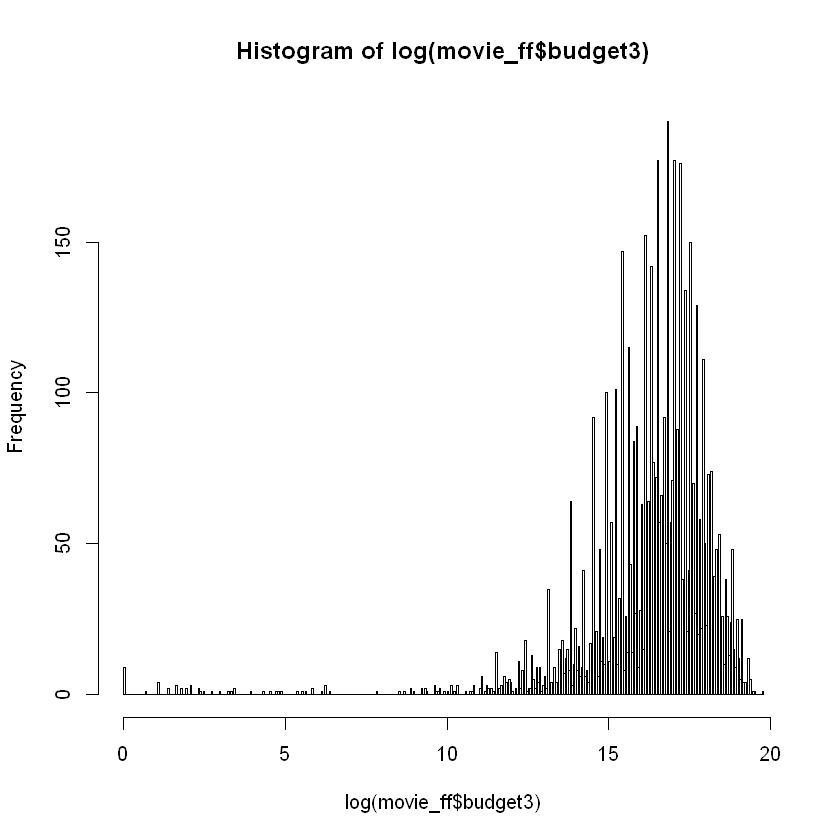

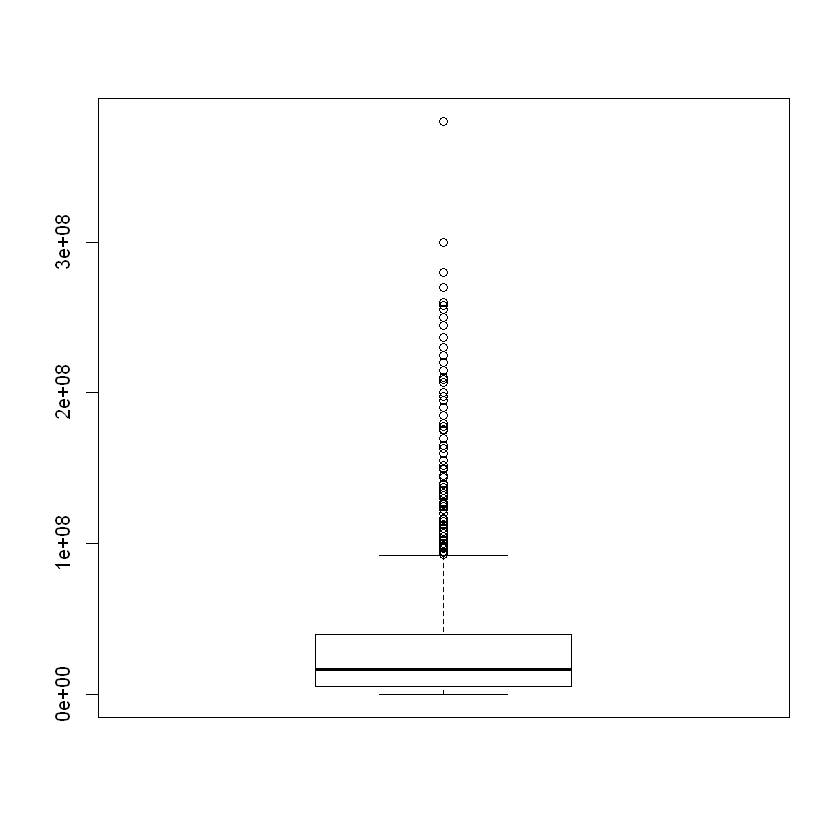

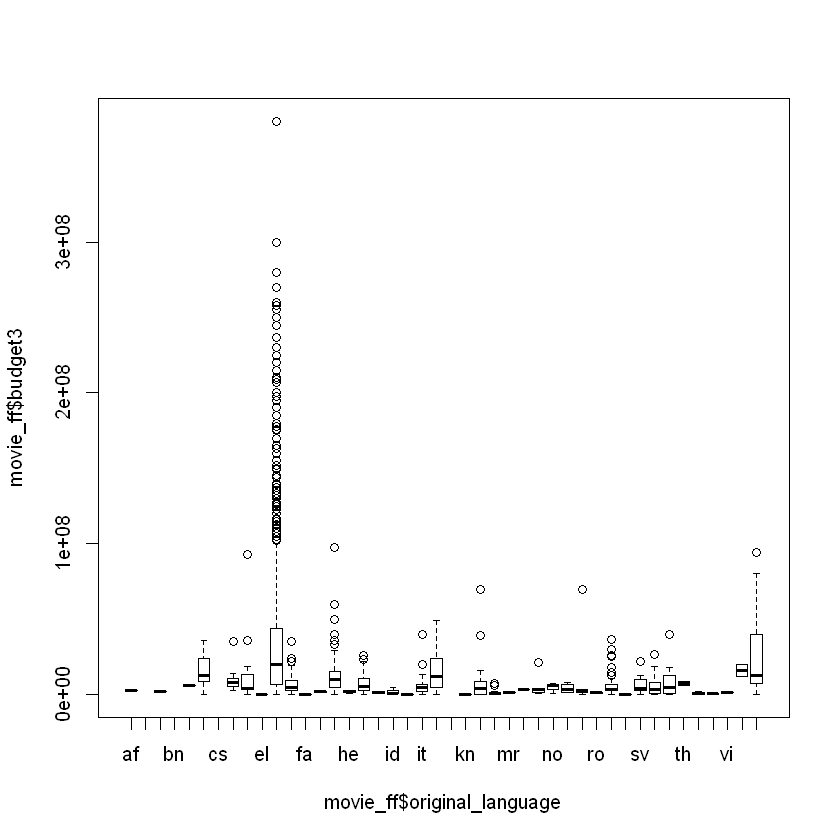

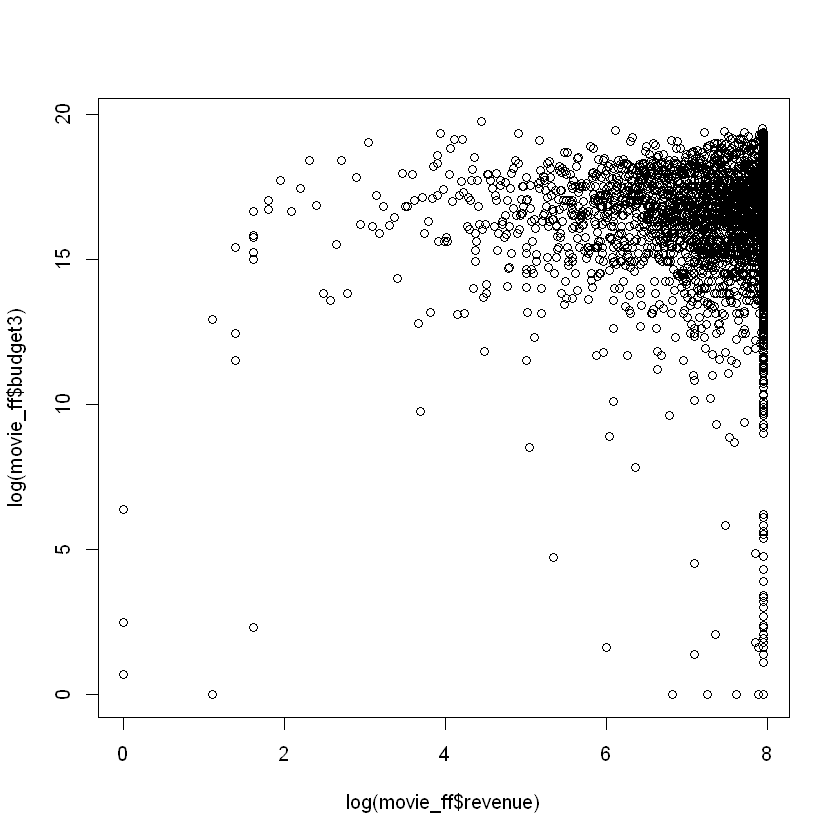

In [83]:
#### chanage 0 to NA
movie_ff$budget3 <- movie_ff$budget
movie_ff$budget3[movie_ff$budget3==0] <- NA
movie_ff$budget3


hist(log(movie_ff$budget3), breaks = 400, na.rm = TRUE)
boxplot(movie_ff$budget3, na.rm = TRUE)
plot(movie_ff$budget3 ~ movie_ff$original_language, na.rm = TRUE)
plot(log(movie_ff$budget3) ~ log(movie_ff$revenue), limX=10)

In [68]:
mod3 <- lm(movie_ff$budget3 ~ movie_ff$revenue)
pred3<-predict(mod3)
abline(reg=mod3, col="red")
summary(mod3)
cor.test(movie_ff$budget3,movie_ff$revenue,method="spearman")


pred3<-predict(mod3)
abline(reg=mod3, col="red")
summary(mod3)
cor.test(movie_ff$budget2,movie_ff$revenue,method="spearman")

ERROR: Error in int_abline(a = a, b = b, h = h, v = v, untf = untf, ...): plot.new has not been called yet


In [84]:
Q <- quantile(movie_ff$budget3, probs=c(.25, .75), na.rm = TRUE)
iqr<-IQR(movie_ff$budget3, na.rm=TRUE)
lower<-Q[1]-1.5*iqr
lower
higher<-Q[2]+1.5*iqr
outliers <- boxplot(movie_ff$budget3, plot=FALSE)$out
outliers

25% 
-4.7e+07

[1] 102000000 140000000 125000000 150000000 100000000  93000000 150000000
  [8] 110000000 180000000 100000000 110000000 102000000  98000000 160000000
 [15] 100000000 100000000 108000000 175000000 115000000 135000000 100000000
 [22] 110000000 130000000 100000000 110000000 149000000 150000000 100000000
 [29] 250000000 135000000 125000000 160000000 113000000 103000000 150000000
 [36] 200000000 105000000 130000000 150000000  94000000 110000000 110000000
 [43] 150000000 150000000 200000000 185000000 100000000 250000000 195000000
 [50] 163000000 180000000 100000000 250000000 135000000 100000000 180000000
 [57]  95000000 105000000 220000000 100000000 150000000 100000000 200000000
 [64] 100000000 150000000 105000000 225000000 260000000 110000000 150000000
 [71] 120000000 116000000 165000000 190000000 125000000 270000000 116000000
 [78]  95000000 130000000 145000000 150000000 260000000 110000000 185000000
 [85] 120000000 152000000 120000000  94000000 120000000 130000000 190000000
 [92]  97000000 135000000 200000000 120000000 200000000 130000000 170000000
 [99] 170000000 125000000 108000000 210000000 105000000 180000000 175000000
[106] 120000000 100000000 170000000 207000000 130000000 105000000 140000000
[113] 135000000 100000000 160000000 200000000 160000000 380000000 103000000
[120] 300000000 100000000 195000000 225000000 150000000 120000000 100000000
[127] 175000000 132000000 125000000 120000000  97250400 250000000 150000000
[134] 200000000 165000000 197471676 102000000 105000000 145000000 100000000
[141] 100000000 125000000 245000000 120000000 280000000 115000000 100000000
[148]  95000000 120000000 130000000 150000000 127500000 140000000 130000000
[155] 100000000 200000000 140000000 200000000 135000000 160000000 258000000
[162] 150000000 120000000  92620000 100000000 140000000 125000000 110000000
[169] 120000000 110000000 150000000 140000000 200000000  95000000 130000000
[176] 125000000 150000000 185000000 115000000 180000000 130000000 137000000
[183] 170000000 150000000 175000000 145000000 165000000 140000000  93000000
[190] 140000000 200000000 130000000 160000000 112000000 140000000 160000000
[197] 155000000 110000000 175000000 100000000 125000000 110000000 180000000
[204] 165000000 140000000 150000000 175000000 100000000 110000000 200000000
[211] 150000000 210000000 140000000 215000000 190000000 150000000 160000000
[218] 100000000 110000000 150000000 170000000 127000000 175000000 175000000
[225] 105000000 105000000 165000000 150000000 185000000  98000000 175000000
[232] 100000000 160000000 110000000 100000000 100000000  97000000 120000000
[239] 225000000  94000000 140000000 150000000 135000000 200000000 250000000
[246]  95000000 150000000 245000000 100000000 150000000 110000000 103000000
[253] 110000000 260000000 200000000 175000000 150000000 110000000 250000000
[260] 145000000 200000000 117000000 250000000 150000000 100000000 175000000
[267] 145000000 100000000 135000000 100000000 145000000 165000000 150000000
[274] 130000000 178000000 130000000 110000000 150000000 150000000  95000000
[281] 120000000  95000000 110000000 185000000 123000000 170000000 100000000
[288] 180000000 150000000 115000000 149000000 130000000 100000000 125000000
[295] 145000000 130000000 100000000 200000000 150000000 200000000 100000000
[302] 150000000 150000000 176000003 230000000 175000000 100000000 100000000
[309] 125000000 105000000 132000000 130000000 150000000 130000000 150000000
[316] 125000000 110000000 150000000 150000000 107000000 100000000 165000000
[323] 100000000 140000000 160000000 120000000 200000000 100000000 125000000
[330] 137000000 160000000 125000000 250000000 155000000 237000000 165000000
[337] 125000000 139000000 200000000 100000000 100000000 100000000 150000000
[344] 140000000 115000000 144000000 110000000 110000000 125000000 140000000
[351] 120000000 200000000 130000000  94000000 150000000 170000000 150000000
[358] 170000000 255000000 150000000 130000000 120000000 125000000 135000000
[365] 200000000 250000000 100000000 209000000 1780

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
       0        0  6000000 15757736 25000000 92000000      394 

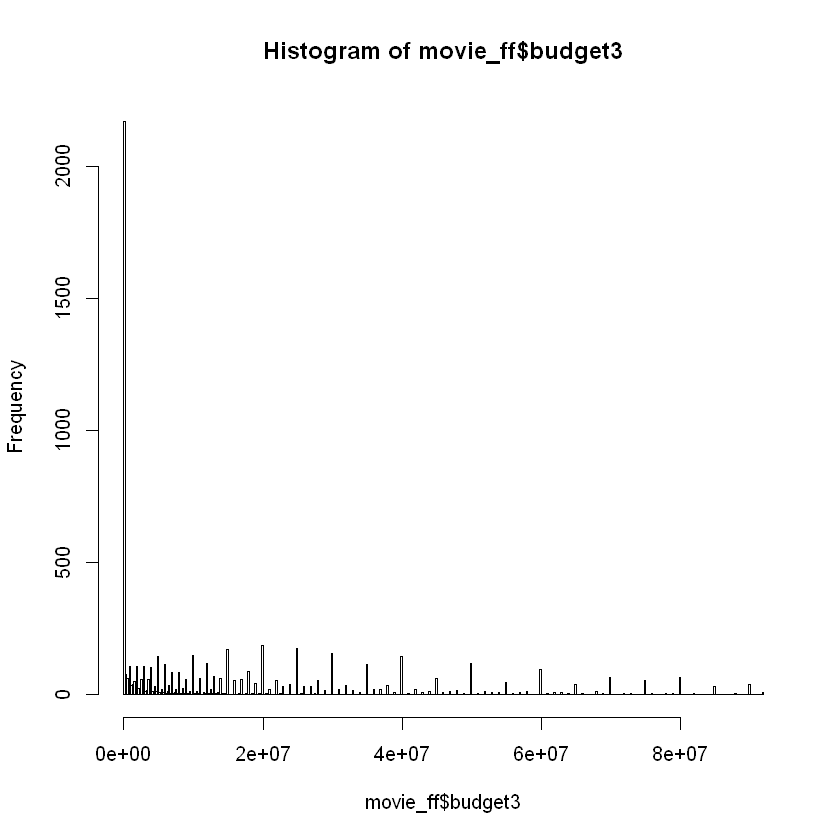

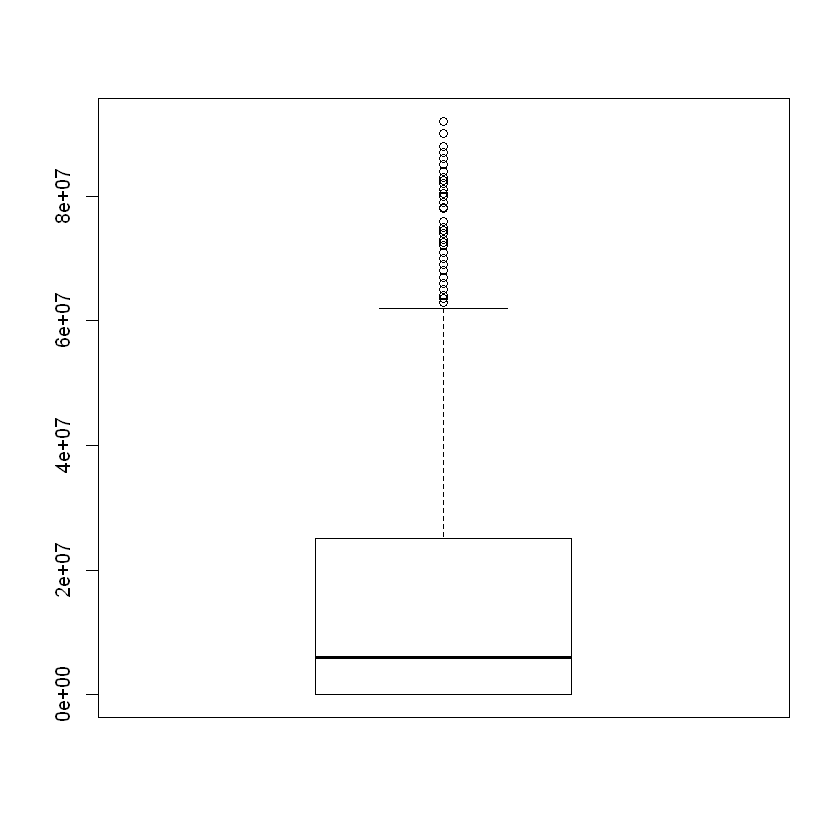


Call:
lm(formula = movie_ff$budget3 ~ movie_ff$revenue)

Residuals:
      Min        1Q    Median        3Q       Max 
-16771313 -15494535  -9494535   8505465  76505465 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      16771762.3   693310.3   24.19   <2e-16 ***
movie_ff$revenue     -448.9      285.9   -1.57    0.116    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 21090000 on 6979 degrees of freedom
  (394 observations deleted due to missingness)
Multiple R-squared:  0.0003532,	Adjusted R-squared:  0.00021 
F-statistic: 2.466 on 1 and 6979 DF,  p-value: 0.1164



	Spearman's rank correlation rho

data:  movie_ff$budget3 and movie_ff$revenue
S = 5.73e+10, p-value = 0.3787
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.01053739 


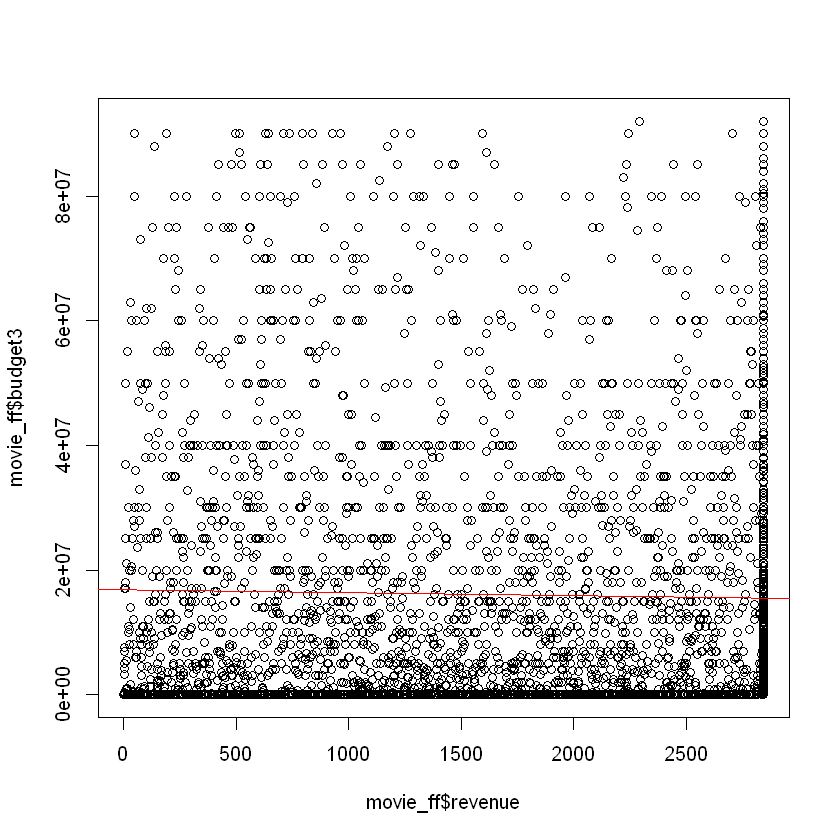

In [86]:
#### check distribution without outliers
movie_ff$budget3 <- movie_ff$budget
movie_ff$budget3[movie_ff$budget3 < lower | movie_ff$budget3 > higher] <- NA
summary(movie_ff$budget3)
hist(movie_ff$budget3, breaks = 400, na.rm = TRUE)
hist(movie_ff$budget3, breaks = 400, na.rm = TRUE)
boxplot(movie_ff$budget3, na.rm = TRUE)
plot(movie_ff$budget3 ~ movie_ff$revenue)
mod3 <- lm(movie_ff$budget3 ~ movie_ff$revenue)
pred3<-predict(mod3)
abline(reg=mod3, col="red")
summary(mod3)
cor.test(movie_ff$budget3,movie_ff$revenue,method="spearman")


In [96]:
movie_ff$revenue

[1]  293 2793  368  616 1751 1516 2663 1243 1573  831  229 1075 1629 2795
  [15] 1638  902 2187  295  742 2655  413 1664   20  701 2006 2639  427 2553
  [29] 2198 2789 1852 1641  496 2445 1239 1783  551  850 2747  520  644  638
  [43] 1169   50 1961 1864 2345  596 2333  265  536 1218  148  747 1933 1652
  [57]   99 1141  253 1231 2231  477 1213  438  755  241  954  578  371  608
  [71]  991  679 2616  733 1104 1192 2021 1765 1628 2540 2758  217 2745 1785
  [85]  369  555  105 1511  373  440  784 1012  537 1306  926  472 1557 2471
  [99] 1105 1953 2754 1467  531 2092  530  662  549  983  812 1580 2370 1046
 [113] 2777 2060 2685 1824 1458 1221  773  841 1593 1910 2141 2732 2253 2485
 [127]  588  269 1938 2178 2830 2069 1179  995 1526 1405  275 1873 1440 1793
 [141]  438 1468 2270 1716  148 2743  887 2675  501 1868  776  690 1158 2078
 [155] 2047  144 2615 1909  880  814  194  290 1491  709 2286 1195  718  480
 [169] 1831 1182 2137 1242  264 1337 1376  971  514 2097  318  597 1462  979
 [183] 1031  750 1137  625 1722 2748 2071  649  675 2568 1709  374 2492  211
 [197]  415 2539  301  857  478 1747  149 2085    5 1331  582 2342 1874  129
 [211] 1284 1957 1572 1453  896  734 2622 2658 2030 1478  110 2503 1477 1615
 [225] 2020 2340 1373 1256 2306 1185 2454   13 1056  967 2665 1308 2146  639
 [239] 2035 2183 2188  824 2587  748 1882  832 1611 2751  498  484 1855   15
 [253] 2025 1424 1585 2541  942 2717 1090  439  829 2689  754  436  473  365
 [267] 2152 1470 1145  917 2463  643 1932 2636 1206 2238  438  656 1107 1028
 [281]    2 2352  346 1129 1976  630 1322 2388 1126  193 1229 2106  651 1457
 [295] 2331 2204 2075 2158 2798 1252 1983 1354 1388 1091 2276  878   10 1077
 [309] 1030  150 2644  288  260 2290 1604  186  243 1360 1324 2395 2498  798
 [323] 2099  632 2165 1387  220 2260  956 1724 2142 2195 1586 1509 1403 1719
 [337]  234 2834 1317 1042  344 2247  563 2698 2038  492 2687    1 1529 1609
 [351]  284  218 2790   55   33 1755  249 2556  485 2774 1475 2816 2080 1237
 [365] 2241 1849   44  657 1555 2312  248 1802 2741  104  700  730   23 2043
 [379]  886 2619  707 2281  918 2400   18 1100  261  400 1001  891  113 2838
 [393]  331  355 2455 2719 1507  868 2504 2544 2196 2236 2613  494 2597  321
 [407]  456 2358 1788 1804  804  515 2823 2811  771  532 2413 1687 1930 2022
 [421]  545 1801 1394 1395 2424 2311  791  927  323  143 1566 2806  139  510
 [435]  165 1414 2429  619 2044 1357 1561  909 2624 1864 1970 1575 2690 1223
 [449] 1471 2230  260  769   35  319 1708 2002 2236 1567 2709 1222  944  511
 [463]  710  330  572  835 1298  414 1484  207 1926  743 1103 2327  627 2302
 [477] 1853 1050  669  358 2781 1635  833 1546  584  827 1588  137 2259  719
 [491] 2295 2349 1703 2472  244 1640 1890 1194 1965 2489 2068 1476  366  232
 [505]  121 2357   57 1504  428 2805  883 1196   46 2102  992 2236  302 2606
 [519] 1344  790 1656 1369  289 2652 1219  735 1830 2237 1714 1641 1074 2814
 [533]  328 1950 2770  866 1554 1968 2282  341 2571 1770 2761  919 2416  101
 [547]  648 2600 1140 2826   81  461  153 2802 2235 1990 1066 1936 1702  628
 [561]  615  894 1658 2766 2590 2561 1671  760 1742 2618  687 2496   12  996
 [575]  969 1992 2541  308 2697 2581 1935 1772 1240  132 1454 1885 1465 2022
 [589] 2169 2721 1124 1908  169 1517 1006  985   24  208 1862 1632 2240  231
 [603] 2103 1278  148 1093 1863 1472 1310 1700  907 2605  695 1370  152  698
 [617]  230 1300 2014  763 2633 1792  420 2648  495 2155 1381 2274  306  141
 [631]  536 1416 1533 1904  928 1657  544  437 2573 2483 2820 1368 2580 2132
 [645]    4 2782 1196  645  871  405  286 2007 2840 2133 1053  924  359 2501
 [659] 2594  379   14  672  786 2415    2 2803 1569 1838 2518 1452 2213 1600
 [673] 1723 2522  196 2252 2536  353 2688 2116  148 1947  803  329 1705 2669
 [687]  425  182 2653 2236  212  783 1178 2228  916  919 1283 2729  311 1733
 [701] 2836 1128 2021 2232 1666  474  422  964   79 2792 1881  272   47 1378
 [715] 1163  772  493 1519  852 1906 2288 2484   83 2432 2442 1812 1039  673

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    4.00    7.00    6.76   10.00   13.00 


 13   1   5   3   7   6  10   8   9  11   4   2  12 
  1 510 518 540 557 561 564 582 594 657 694 695 902 

[1] 0

[1] 13

[1] 902

[1] "table"

Number of cases in table: 7375 
Number of factors: 1 


  1   2   3   4   5   6   7   8   9  10  11  12  13 
510 695 540 694 518 561 557 582 594 564 657 902   1 

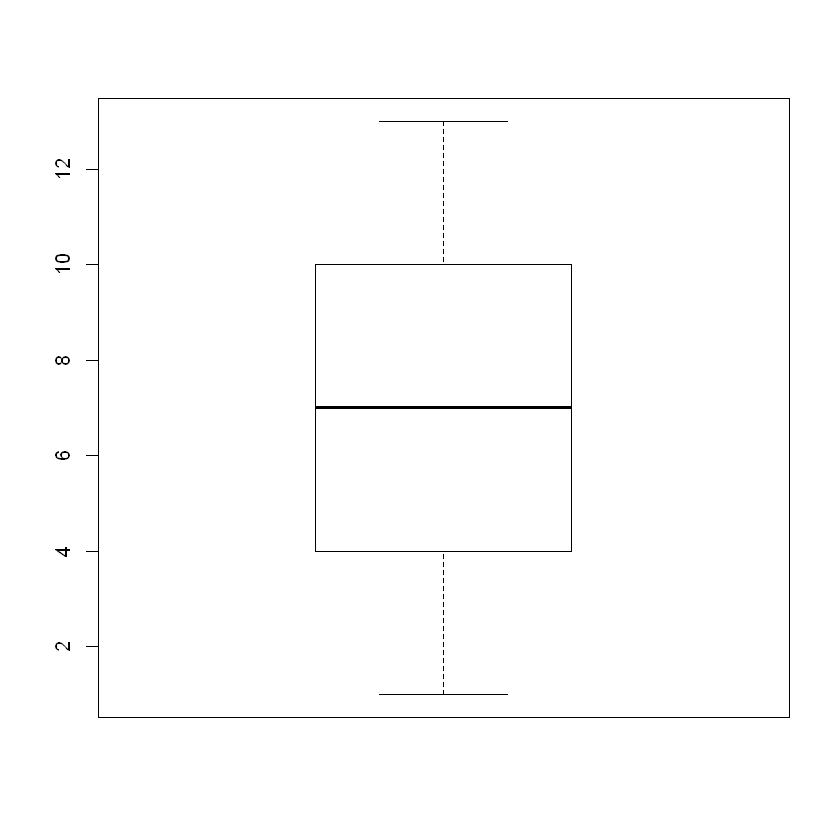

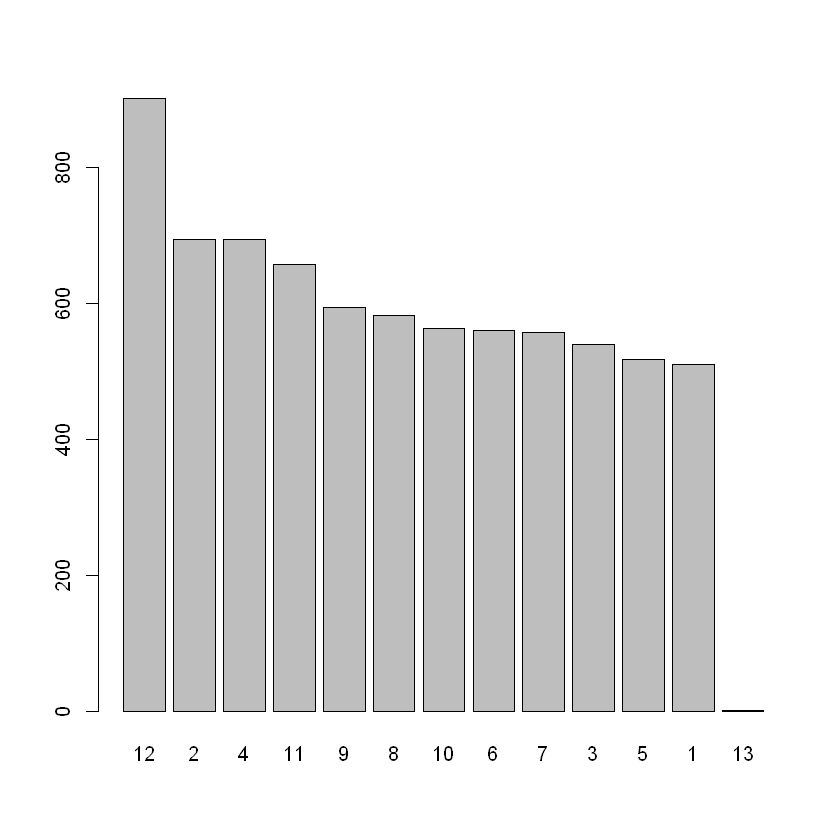

In [38]:
summary(movie_ff$release_month)
sort(table(movie_ff$release_month))
sum(is.na(movie_ff$release_month))
nrow(table(movie_ff$release_month))
max(table(movie_ff$release_month))
boxplot(movie_ff$release_month)
t <- table((movie_ff$release_month))
class(t)
summary(t)
t
barplot(sort(table(movie_ff$release_month), decreasing = TRUE))

In [34]:
barplot(movie_ff$release_month), decreasing = TRUE))

ERROR: Error in parse(text = x, srcfile = src): <text>:1:32: unexpected ','
1: barplot(movie_ff$release_month),
                                   ^


In [51]:
### Mechkar analysis:
exploreData(movie_ff, budget)

ERROR: Error in ifelse(is.null(y) == TRUE, "", "<div class='Cell Title'> Dependent <br> Variable <br> Distribution </div>"): object 'budget' not found


In [68]:
num1 <- select(df, budget,release_date,sw_lang_en,sw_tagline,release_month,seasonality,countries_cnt,lang_RU,actor0_movies_cnt,actor1_movies_5y_cnt,sw_female_actor0,sw_male_actor0,actor0_prev_revenue,director_movies_cnt,genre_fantasy,genre_horror,genre_history,genre_crime,genre_mystery,genre_family,depart_Art,depart_Custom_Mkup,depart_Lighting,depart_Visual_Effects,depart_Camera_female,depart_Directing_female,depart_Production_female,depart_Writing_female)
num1

ERROR: Error in select(df, budget, release_date, sw_lang_en, sw_tagline, release_month, : could not find function "select"


In [63]:
movie_ff %>% select(is.numeric)

ERROR: Error in movie_ff %>% select_if(is.numeric): could not find function "%>%"


In [49]:
### Not sure what this is:
Table1(data=movie_ff)##, x=names(movie_ff), y="Category")

  |                                                                      |   0%

ERROR: Error in data %>% filter(is.na(v) == TRUE): could not find function "%>%"


In [43]:
getMissingness(movie_ff)

list(var = integer(0), na_count = numeric(0), rate = numeric(0))This dataset has 7375 (100%) complete rows. Original data has 7375 rows.


var,na_count,rate


In [47]:
mm <- getMissingness(movie_ff,getRows = T)
df.full <- movie_ff[mm$rows,]

list(var = integer(0), na_count = numeric(0), rate = numeric(0))This dataset has 7375 (100%) complete rows. Original data has 7375 rows.


In [48]:
### Not sure what this is:
summary(df.full)

  ï..movie_id   original_title     budget          original_language
 Min.   :   1   ????   :  51   Min.   :        0   en     :6336     
 1st Qu.:1848   ???    :  36   1st Qu.:        0   fr     : 199     
 Median :3696   ?????  :  24   Median :  8000000   hi     : 118     
 Mean   :3698   ???????:  24   Mean   : 22666657   ru     : 105     
 3rd Qu.:5550   ??     :  20   3rd Qu.: 29000000   es     :  95     
 Max.   :7398   ?????? :  20   Max.   :380000000   ja     :  90     
                (Other):7200                       (Other): 432     
   popularity      popularity_group     release_date     runtime      
 Min.   :  0.000   7      : 617     2010-09-10:  10   Min.   :  1.00  
 1st Qu.:  3.970   8      : 615     2011-09-09:   8   1st Qu.: 13.00  
 Median :  7.456   1      : 582     2005-09-16:   7   Median : 34.00  
 Mean   :  8.540   6      : 580     2008-12-25:   7   Mean   : 74.71  
 3rd Qu.: 10.932   9      : 533     2009-01-16:   7   3rd Qu.:158.00  
 Max.   :547.488   10 

In [25]:
cor.test(movie_ff$revenue~movie_ff$budget)

ERROR: Error in cor.test.formula(movie_ff$revenue ~ movie_ff$budget): 'formula' missing or invalid
